<h1 align="center">Marketing Mix Modeling Case Study</h1>
<h3 align="center">Channel Impact Analysis & Optimization Strategy</h3>
<h4 align="center">- <b>Taroon Ganesh</b> · Data Science Graduate @ USC</h4>



### This notebook walks through:
 1. Data cleaning & transformation from daily logs to an episode week level dataset.
 2. Exploratory data analysis (EDA) focused on viewership and media spend.
 3. Feature engineering tailored to TV seasons and episodes.
 4. Three Ridge-based MMM specifications (log-saturation, adstock, adstock+sat).
 5. Simulation \& Optimization of media spend channels
 6. A separate **Bayesian hill_adstock MMM** (run in Google Colab with lightweightMMM), and how its results compare.
 7. Final recommendation for which model to use for business decisions.
 8. **Extras**: advanced cross-validation, hyperparameter tuning, and stress tests.

#### 0. Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error

plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["axes.titlesize"] = 16
plt.rcParams["axes.labelsize"] = 13
plt.rcParams["axes.grid"] = True

pd.set_option("display.max_columns", 50)

#### 1. Load & Clean Data
We start from the **"silver"** dataset at the *daily* level, where each row is a day with media spends and viewership for a particular show, season, episode, and week.

 - Drop the auto-generated index column if present.
 - Parse `Air_Date` as a datetime.
 - Sort records by `Show`, `Season`, and `Air_Date`.

In [3]:
silver_df = pd.read_csv("Silver_Data.csv")
silver_df.head()

,Unnamed: 0,Show,Season,Air_Date,Week_Number,Episode_Number,Episode_Type,Network_TV_Spend,Cable_TV_Spend,Digital_Spend,Impressions,True_Viewership,Revenue,Holiday,LeadIn_Bonus
0,0,Show2,1,2020-10-05,5,0,PreLaunch,8721.066697,10465.280036,3488.426679,44768143,66845.590114,45352.467143,0,0
1,1,Show4,3,2022-10-15,6,1,Premiere,3524.911498,NaN,8812.278744,38186541,83713.735201,58420.934286,0,0
2,2,Show2,4,2023-10-27,8,3,Regular,6964.236436,2785.694575,8357.083724,30178358,63736.233023,45484.814286,0,0
3,3,Show7,1,2024-03-24,11,6,Regular,NaN,7625.926405,6354.938671,27538068,45117.211196,31663.720000,0,0
4,4,Show5,1,2023-08-14,10,5,Regular,7466.359494,2488.786498,6221.966245,28621044,87525.734172,60840.965714,0,0


In [5]:
silver_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3143 entries, 0 to 3142
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        3143 non-null   int64  
 1   Show              3143 non-null   object 
 2   Season            3143 non-null   int64  
 3   Air_Date          3143 non-null   object 
 4   Week_Number       3143 non-null   int64  
 5   Episode_Number    3143 non-null   int64  
 6   Episode_Type      3143 non-null   object 
 7   Network_TV_Spend  3110 non-null   float64
 8   Cable_TV_Spend    3112 non-null   float64
 9   Digital_Spend     3109 non-null   float64
 10  Impressions       3143 non-null   int64  
 11  True_Viewership   3111 non-null   float64
 12  Revenue           3109 non-null   float64
 13  Holiday           3143 non-null   int64  
 14  LeadIn_Bonus      3143 non-null   int64  
dtypes: float64(5), int64(7), object(3)
memory usage: 368.4+ KB


In [7]:
if "Unnamed: 0" in silver_df.columns:
    silver_df = silver_df.drop(columns=["Unnamed: 0"])

# Parse dates
silver_df["Air_Date"] = pd.to_datetime(silver_df["Air_Date"])

# Sort for consistency
silver_df = silver_df.sort_values(["Show", "Season", "Air_Date"]).reset_index(drop=True)

print("Raw daily-level data shape:", silver_df.shape)
silver_df.head()

Raw daily-level data shape: (3143, 14)


,Show,Season,Air_Date,Week_Number,Episode_Number,Episode_Type,Network_TV_Spend,Cable_TV_Spend,Digital_Spend,Impressions,True_Viewership,Revenue,Holiday,LeadIn_Bonus
0,Show1,1,2020-09-06,1,0,PreLaunch,4028.297704,12084.893113,10070.744261,43639891,117856.38004,82590.005714,0,0
1,Show1,1,2020-09-07,1,0,PreLaunch,4028.297704,12084.893113,10070.744261,43639891,117856.38004,82590.005714,0,0
2,Show1,1,2020-09-08,1,0,PreLaunch,4028.297704,12084.893113,10070.744261,43639891,117856.38004,82590.005714,0,0
3,Show1,1,2020-09-09,1,0,PreLaunch,4028.297704,12084.893113,10070.744261,43639891,NaN,82590.005714,0,0
4,Show1,1,2020-09-10,1,0,PreLaunch,4028.297704,12084.893113,10070.744261,43639891,117856.38004,82590.005714,0,0


In [9]:
silver_df.isna().sum()
silver_df.describe(include='all')

,Show,Season,Air_Date,Week_Number,Episode_Number,Episode_Type,Network_TV_Spend,Cable_TV_Spend,Digital_Spend,Impressions,True_Viewership,Revenue,Holiday,LeadIn_Bonus
count,3143,3143.000000,3143,3143.000000,3143.000000,3143,3110.000000,3112.000000,3109.000000,3.143000e+03,3111.000000,3109.000000,3143.000000,3143.000000
unique,8,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,Show4,NaN,NaN,NaN,NaN,Regular,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,574,NaN,NaN,NaN,NaN,1687,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,2.572383,2023-04-06 08:58:47.839643648,8.008909,3.674833,NaN,10873.452812,10916.576686,11715.438002,5.892010e+07,127512.375913,89497.789960,0.069042,0.060134
min,NaN,1.000000,2020-09-06 00:00:00,1.000000,0.000000,NaN,1737.959827,2158.075740,2039.800603,1.795892e+07,33054.486655,23264.130000,0.000000,0.000000
25%,NaN,1.000000,2021-11-25 00:00:00,4.000000,0.000000,NaN,5257.310701,6241.098949,7247.001977,3.972746e+07,71046.387020,50241.310000,0.000000,0.000000
50%,NaN,2.000000,2023-09-05 00:00:00,8.000000,3.000000,NaN,9343.821830,9042.396892,10619.142534,5.853256e+07,106877.147574,75751.057143,0.000000,0.000000
75%,NaN,4.000000,2024-07-31 00:00:00,12.000000,7.000000,NaN,15932.598611,15477.804203,15881.544689,7.399226e+07,192154.375494,134695.304286,0.000000,0.000000
max,NaN,5.000000,2025-04-26 00:00:00,15.000000,10.000000,NaN,29201.760073,27829.401203,27665.920853,1.178540e+08,261690.322671,181578.090000,1.000000,1.000000


In [11]:
silver_df[(silver_df["Show"] == "Show1") & (silver_df["Season"] == 1) & (silver_df["Week_Number"] == 1)].sort_values("Air_Date")

,Show,Season,Air_Date,Week_Number,Episode_Number,Episode_Type,Network_TV_Spend,Cable_TV_Spend,Digital_Spend,Impressions,True_Viewership,Revenue,Holiday,LeadIn_Bonus
0,Show1,1,2020-09-06,1,0,PreLaunch,4028.297704,12084.893113,10070.744261,43639891,117856.38004,82590.005714,0,0
1,Show1,1,2020-09-07,1,0,PreLaunch,4028.297704,12084.893113,10070.744261,43639891,117856.38004,82590.005714,0,0
2,Show1,1,2020-09-08,1,0,PreLaunch,4028.297704,12084.893113,10070.744261,43639891,117856.38004,82590.005714,0,0
3,Show1,1,2020-09-09,1,0,PreLaunch,4028.297704,12084.893113,10070.744261,43639891,NaN,82590.005714,0,0
4,Show1,1,2020-09-10,1,0,PreLaunch,4028.297704,12084.893113,10070.744261,43639891,117856.38004,82590.005714,0,0
5,Show1,1,2020-09-11,1,0,PreLaunch,4028.297704,12084.893113,10070.744261,43639891,117856.38004,82590.005714,0,0
6,Show1,1,2020-09-12,1,0,PreLaunch,4028.297704,12084.893113,10070.744261,43639891,117856.38004,82590.005714,0,0


**The Silver dataset initially appears to contain duplicates because many rows repeat the same spend, impressions, viewership, revenue, holiday, lead-in, etc.**

However, after inspecting several shows, it becomes clear that:

 - The data is daily-level, not episode-level.
 - Each episode week has 7 entries (one per day).
 - All marketing inputs and outputs are identical across the week.
 - The only column changing is **Air_Date**, because it's a daily breakdown
 - Therefore, what appear to be duplicates are actually daily entries for the same weekly campaign.

This validates the requirement to aggregate from Silver (daily) → Gold (weekly)

#### 1.1 Aggregate to Episode–Week Level (`df_gold`)

 On observing the data:
 - 8 shows.
 - Some shows have 5 seasons, others 2.
 - Each season runs for 15 weeks:
   - Weeks 1–5: `Episode_Number = 0` (PreLaunch).
   - Week 6: `Episode_Number = 1` (Premiere).
   - Weeks 7–15: Regular episodes and finale.

 The daily data may have multiple rows per episode week (e.g., multiple days).
 For modeling, we want **one row per (Show, Season, Week_Number, Episode_Number)**.

 We aggregate by:
 - `Air_Date`: earliest date in that episode–week.
 - `Episode_Type`: first (they're consistent within a week).
 - Media spends, Impressions, Viewership, Revenue: first (already weekly-level), assuming they represent the weekly total for that episode–week.

In [13]:
key_cols = ["Show", "Season", "Week_Number", "Episode_Number"]

agg_dict = {
    "Air_Date": "min",
    "Episode_Type": "first",
    "Network_TV_Spend": "first",
    "Cable_TV_Spend": "first",
    "Digital_Spend": "first",
    "Impressions": "first",
    "True_Viewership": "first",
    "Revenue": "first",
    "Holiday": "first",
    "LeadIn_Bonus": "first",
}

df_gold = (
    silver_df.groupby(key_cols, as_index=False)
      .agg(agg_dict)
      .sort_values(["Show", "Season", "Air_Date"])
      .reset_index(drop=True)
)

print("Episode–week level data shape:", df_gold.shape)
df_gold.head()

Episode–week level data shape: (420, 14)


,Show,Season,Week_Number,Episode_Number,Air_Date,Episode_Type,Network_TV_Spend,Cable_TV_Spend,Digital_Spend,Impressions,True_Viewership,Revenue,Holiday,LeadIn_Bonus
0,Show1,1,1,0,2020-09-06,PreLaunch,4028.297704,12084.893113,10070.744261,43639891,117856.380040,82590.005714,0,0
1,Show1,1,2,0,2020-09-13,PreLaunch,4854.153125,14562.459375,12135.382813,52586659,129214.055887,88792.032857,0,0
2,Show1,1,3,0,2020-09-20,PreLaunch,5370.453364,16111.360093,13426.133411,58179911,171609.757399,121836.521429,0,0
3,Show1,1,4,0,2020-09-27,PreLaunch,7619.321690,22857.965070,19048.304225,82542651,178971.843013,124396.604286,0,0
4,Show1,1,5,0,2020-10-04,PreLaunch,7133.216268,21399.648804,17833.040670,77276510,192167.775786,131526.194286,0,0


#### 1.2 Verify Missing Values After Aggregation

In [15]:
print("Missing values in Gold dataset:")
print(df_gold.isna().sum())

Missing values in Gold dataset:
Show                0
Season              0
Week_Number         0
Episode_Number      0
Air_Date            0
Episode_Type        0
Network_TV_Spend    0
Cable_TV_Spend      0
Digital_Spend       0
Impressions         0
True_Viewership     0
Revenue             0
Holiday             0
LeadIn_Bonus        0
dtype: int64


#### 1.3 Aggregation Validation

In [17]:
# Weekly impressions
silver_weekly = (
    silver_df.groupby(['Show','Season','Week_Number'])['Impressions']
    .max()
    .rename('Silver_Weekly_Impressions')
)

gold_weekly = (
    df_gold.groupby(['Show','Season','Week_Number'])['Impressions']
    .first()
    .rename('Gold_Impressions')
)

# Weekly spend
silver_weekly_spend = silver_df.groupby(['Show','Season','Week_Number'])[
    ['Network_TV_Spend','Cable_TV_Spend','Digital_Spend']
].max().add_prefix('Silver_')

gold_weekly_spend = df_gold.groupby(['Show','Season','Week_Number'])[
    ['Network_TV_Spend','Cable_TV_Spend','Digital_Spend']
].first().add_prefix('Gold_')

validation = pd.concat(
    [silver_weekly, gold_weekly, silver_weekly_spend, gold_weekly_spend],
    axis=1
)

# Row-level match logic ---
validation['Impressions_Match'] = (
    validation['Silver_Weekly_Impressions'] == validation['Gold_Impressions']
)

validation['Spend_Match'] = (
    (validation['Silver_Network_TV_Spend'] == validation['Gold_Network_TV_Spend']) &
    (validation['Silver_Cable_TV_Spend']   == validation['Gold_Cable_TV_Spend']) &
    (validation['Silver_Digital_Spend']    == validation['Gold_Digital_Spend'])
)

validation['All_Match'] = validation['Impressions_Match'] & validation['Spend_Match']

print(validation.head())

validation['All_Match'].all() #To check if theres any mismatch

                          Silver_Weekly_Impressions  Gold_Impressions  \
Show  Season Week_Number                                                
Show1 1      1                             43639891          43639891   
             2                             52586659          52586659   
             3                             58179911          58179911   
             4                             82542651          82542651   
             5                             77276510          77276510   

                          Silver_Network_TV_Spend  Silver_Cable_TV_Spend  \
Show  Season Week_Number                                                   
Show1 1      1                        4028.297704           12084.893113   
             2                        4854.153125           14562.459375   
             3                        5370.453364           16111.360093   
             4                        7619.321690           22857.965070   
             5                  

True

#### 1.4 Date Range Check

In [19]:
print(silver_df['Air_Date'].min(), silver_df['Air_Date'].max())
print(df_gold['Air_Date'].min(), df_gold['Air_Date'].max())

2020-09-06 00:00:00 2025-04-26 00:00:00
2020-09-06 00:00:00 2025-04-20 00:00:00


##### We now have **420 rows** (8 shows × seasons × 15 weeks) and **no missing values** in key fields and is **validated**. This `df_gold` will be our modeling base.

#### 1.3 Campaign Reports

We build three simple campaign reports from the gold layer:
1) **Show × Channel** treating each show as a campaign
2) **Episode_Type × Channel** to understand lifecycle investment  
3) **Overall Channel** view across all activity.

For each grain, we sum **Total_Spend** and **Total_Impressions**, then compute:
- **Spend share** within each show/episode type/channel group, and  
- **CPM** as `Total_Spend / (Total_Impressions / 1,000)`

Because impressions are only available at the campaign level (not split by channel), CPM is interpreted as an **effective CPM** for that channel using campaign-level impressions.

#### 1.3.1 Spend & CPM by Show and Channel

In [21]:
channels = ["Network_TV_Spend", "Cable_TV_Spend", "Digital_Spend"]
channel_map = {
    "Network_TV_Spend": "Network",
    "Cable_TV_Spend": "Cable",
    "Digital_Spend": "Digital",
}

# 1) Total impressions per Show (campaign-level)
show_impr = (
    df_gold
    .groupby("Show", as_index=False)
    .agg(Total_Impressions=("Impressions", "sum"))
)

# 2) Total spend per Show × Channel
df_long_show = df_gold.melt(
    id_vars=["Show"],
    value_vars=channels,
    var_name="Channel_Col",
    value_name="Spend"
)
df_long_show["Channel"] = df_long_show["Channel_Col"].map(channel_map)

show_channel_spend = (
    df_long_show
    .groupby(["Show", "Channel"], as_index=False)
    .agg(Total_Spend=("Spend", "sum"))
)

# 3) Join impressions + add metrics
report_show = show_channel_spend.merge(show_impr, on="Show", how="left")

# Share of spend within each Show
report_show["Spend_Share_in_Show"] = (
    report_show["Total_Spend"] /
    report_show.groupby("Show")["Total_Spend"].transform("sum")
)

# CPM = cost per 1,000 impressions
report_show["CPM"] = report_show["Total_Spend"] / (report_show["Total_Impressions"] / 1000.0)

report_show = report_show.sort_values(["Show", "Channel"])

report_show.style.format({
    "Total_Spend": "${:,.0f}",
    "Total_Impressions": "{:,.0f}",
    "Spend_Share_in_Show": "{:.1%}",
    "CPM": "${:,.2f}"
})

,Show,Channel,Total_Spend,Total_Impressions,Spend_Share_in_Show,CPM
0,Show1,Cable,"$948,019","5,447,333,534",30.6%,$0.17
1,Show1,Digital,"$1,094,937","5,447,333,534",35.4%,$0.20
2,Show1,Network,"$1,052,725","5,447,333,534",34.0%,$0.19
3,Show2,Cable,"$530,207","3,527,950,374",26.0%,$0.15
4,Show2,Digital,"$783,418","3,527,950,374",38.5%,$0.22
5,Show2,Network,"$721,765","3,527,950,374",35.5%,$0.20
6,Show3,Cable,"$1,065,501","5,649,499,970",33.7%,$0.19
7,Show3,Digital,"$1,023,623","5,649,499,970",32.4%,$0.18
8,Show3,Network,"$1,069,233","5,649,499,970",33.9%,$0.19
9,Show4,Cable,"$721,945","3,526,360,166",35.3%,$0.20


Across most shows, spend is fairly balanced between Network, Cable, and Digital, with each channel taking roughly **30–40%** of that show’s budget. Effective CPMs are tightly clustered around **\$0.17** – **\$0.21**, but there are notable nuances: for example, **Show7** leans heavily into Cable/Digital by spend, yet **Network delivers the lowest effective CPM (~\$0.09)**, suggesting it’s the most cost-efficient reach driver for that show. Shows like **Show5** put a larger share into Digital (42%+) and see a higher CPM (~\$0.25), implying a trade-off between targeting/flexibility and pure cost efficiency.

#### 1.3.2 Spend & CPM by Episode Type and Channel

In [23]:
channels = ["Network_TV_Spend", "Cable_TV_Spend", "Digital_Spend"]
channel_map = {
    "Network_TV_Spend": "Network",
    "Cable_TV_Spend": "Cable",
    "Digital_Spend": "Digital",
}

# 1) Total impressions per Episode_Type
etype_impr = (
    df_gold
    .groupby("Episode_Type", as_index=False)
    .agg(Total_Impressions=("Impressions", "sum"))
)

# 2) Total spend per Episode_Type × Channel
df_long_etype = df_gold.melt(
    id_vars=["Episode_Type"],
    value_vars=channels,
    var_name="Channel_Col",
    value_name="Spend"
)
df_long_etype["Channel"] = df_long_etype["Channel_Col"].map(channel_map)

etype_channel_spend = (
    df_long_etype
    .groupby(["Episode_Type", "Channel"], as_index=False)
    .agg(Total_Spend=("Spend", "sum"))
)

# 3) Join + metrics
report_etype = etype_channel_spend.merge(etype_impr, on="Episode_Type", how="left")

# Share of spend within each Episode_Type
report_etype["Spend_Share_in_Type"] = (
    report_etype["Total_Spend"] /
    report_etype.groupby("Episode_Type")["Total_Spend"].transform("sum")
)

# CPM by type × channel
report_etype["CPM"] = report_etype["Total_Spend"] / (report_etype["Total_Impressions"] / 1000.0)

report_etype = report_etype.sort_values(["Episode_Type", "Channel"])

report_etype.style.format({
    "Total_Spend": "${:,.0f}",
    "Total_Impressions": "{:,.0f}",
    "Spend_Share_in_Type": "{:.1%}",
    "CPM": "${:,.2f}",
})

,Episode_Type,Channel,Total_Spend,Total_Impressions,Spend_Share_in_Type,CPM
0,Finale,Cable,"$343,192","1,857,456,386",32.2%,$0.18
1,Finale,Digital,"$386,234","1,857,456,386",36.2%,$0.21
2,Finale,Network,"$336,359","1,857,456,386",31.6%,$0.18
3,PreLaunch,Cable,"$1,535,725","8,329,430,703",32.3%,$0.18
4,PreLaunch,Digital,"$1,687,436","8,329,430,703",35.5%,$0.20
5,PreLaunch,Network,"$1,530,233","8,329,430,703",32.2%,$0.18
6,Premiere,Cable,"$316,629","1,731,108,774",32.3%,$0.18
7,Premiere,Digital,"$339,475","1,731,108,774",34.6%,$0.20
8,Premiere,Network,"$325,018","1,731,108,774",33.1%,$0.19
9,Regular,Cable,"$2,329,589","12,719,389,838",32.3%,$0.18


Spend by episode type is very consistent across channels: for **PreLaunch, Premiere, Regular, and Finale**, each of Network/Cable/Digital usually gets ~**32-36%** of total spend for that stage. Effective CPMs by type and channel are also stable (≈ **\$0.18** - **\$0.21**), meaning we're getting impressions at similar efficiency across the season arc. Digital tends to sit at the **top of the CPM range**, indicating a slight **cost premium** for digital impressions, whereas Network/Cable are marginally cheaper on a pure cost-per-thousand basis.

#### 1.3.3 Overall Channel Mix & Efficiency

In [25]:
# 1) Total impressions overall (campaign-level)
total_impr_overall = df_gold["Impressions"].sum()

# 2) Total spend per Channel across all shows/episodes
df_long_ch = df_gold.melt(
    id_vars=[],
    value_vars=channels,
    var_name="Channel_Col",
    value_name="Spend"
)
df_long_ch["Channel"] = df_long_ch["Channel_Col"].map(channel_map)

channel_spend = (
    df_long_ch
    .groupby("Channel", as_index=False)
    .agg(Total_Spend=("Spend", "sum"))
)

# 3) Add impressions + shares + CPM
channel_spend["Total_Impressions"] = total_impr_overall

channel_spend["Spend_Share_Overall"] = (
    channel_spend["Total_Spend"] / channel_spend["Total_Spend"].sum()
)

channel_spend["CPM"] = channel_spend["Total_Spend"] / (channel_spend["Total_Impressions"] / 1000.0)

channel_report = channel_spend.sort_values("Channel")

channel_report.style.format({
    "Total_Spend": "${:,.0f}",
    "Total_Impressions": "{:,.0f}",
    "Spend_Share_Overall": "{:.1%}",
    "CPM": "${:,.2f}",
})

,Channel,Total_Spend,Total_Impressions,Spend_Share_Overall,CPM
0,Cable,"$4,525,135","24,637,385,701",32.3%,$0.18
1,Digital,"$4,923,768","24,637,385,701",35.1%,$0.20
2,Network,"$4,570,006","24,637,385,701",32.6%,$0.19


At the highest level, **Digital accounts for ~35% of total spend**, with Network and Cable splitting the remaining ~ 65% almost evenly. Effective CPMs show **Digital as the most expensive channel (~\$0.20)**, while **Cable (~\$0.18)** and **Network (~\$0.19)** deliver slightly cheaper impressions overall. This suggests that, from a pure reach-efficiency standpoint, traditional TV (Network/Cable) is marginally more cost-effective, while Digital is likely being used for **incremental reach and targeting** rather than low cost GRPs

### 1.4 Scenario-based Questions

#### Q1 - Purpose & Challenges of Bronze/Silver/Gold Medallion Layers

##### **Bronze Layer**
This is where I land source data exactly as it comes in (ads, ratings, finance, etc.) with almost no transformation so I never lose information. The pain points here are messy files, late/duplicate records, and random schema changes from upstream systems that I have to tolerate rather than “fix.”

##### **Silver Layer**
Here I standardize types, dedupe, apply basic validation, and line things up on common keys so it’s actually usable (this is the Silver daily data I started from). The main challenge is locking in consistent business rules such as how to treat nulls, conflicting values, and joins without surprising any downstream users.

##### **Gold Layer**
Gold is where I reshape the data into **exactly** what the business/model needs (e.g., my episode–week `df_gold` with engineered features for MMM). The tricky part is aggregating without double counting, keeping the schema simple enough for stakeholders, and making sure any upstream change doesn’t silently break these curated outputs.


#### Q2 - Handling Sudden Upstream Schema Change

If the upstream schema suddenly changes, I’d want my Bronze/Silver jobs to **fail fast with clear alerts** instead of quietly producing bad data. I’d route the new data into a safe “quarantine” or shadow table, diff the old vs new schema, then update the Silver transformation logic (casts, mappings, defaults) to handle the new shape. Only after Silver passes sanity checks (row counts, null rates, key integrity) would I let the Gold layer rebuild so models and dashboards don’t see half-broken data. Its also best to have a clone of your data sitting at a differnt storage.


#### Q3 - Data Lineage & Monitoring Across Layers

- Track lineage via a metadata store (Unity Catalog, DataHub, Amundsen, OpenLineage).  
- Log all inputs, row counts, timestamps, and schema at each transformation (Bronze → Silver → Gold).  
- Implement data quality monitors: null checks, distribution drift detection, volume anomalies, duplicate spikes.  
- Create dashboards for daily pipeline health and anomaly alerts.  

This ensures fast root-cause analysis and prevents silent data corruption.

### 2. Exploratory Data Analysis (EDA)

We keep the EDA focused and business-relevant:
 1. Distribution of viewership.
 2. Viewership by episode type (PreLaunch, Premiere, Regular, Finale).
 3. Viewership across the season arc (Episode_Progress).
 4. Relationship between digital spend and viewership.

In [27]:
# Basic descriptive stats for key numeric columns
df_gold[["True_Viewership", "Revenue", "Network_TV_Spend", "Cable_TV_Spend", "Digital_Spend"]].describe().round(2)

,True_Viewership,Revenue,Network_TV_Spend,Cable_TV_Spend,Digital_Spend
count,420.00,420.00,420.00,420.00,420.00
mean,127039.00,89052.88,10880.97,10774.13,11723.26
std,63018.73,44247.54,6464.82,6045.81,5691.95
min,33054.49,23264.13,1737.96,2158.08,2039.80
25%,70815.86,49565.71,5260.39,6171.63,7251.25
50%,107544.12,75403.92,9344.74,8849.25,10635.50
75%,191611.49,133314.07,15935.66,15342.56,15882.92
max,261690.32,181578.09,29201.76,27829.40,27665.92


- Weekly **viewership is pretty spread out**: median is ~108k, but it ranges from ~33k up to ~262k, so there’s a clear mix of weaker and breakout episodes.
- **Revenue tracks that pattern** nicely (mean ~ **\$89k**, max ~ **\$182k**), which is good for later when we convert incremental viewers into dollars.
- The three media channels are **broadly in the same spend ballpark** (means ~\$10–12k per week), so no single channel is completely dominating the budget.
- Each channel has a **wide spend range** (roughly **\$2k** - **\$29k** per week), which gives the model enough variation to actually learn response and saturation instead of guessing around a fixed level.

#### 2.1 Viewership Trend across Months

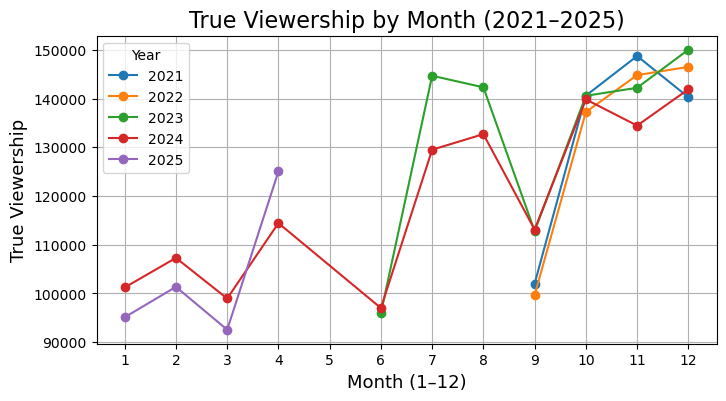

In [29]:
# Convert Air_Date to datetime if not already
df_gold['Air_Date'] = pd.to_datetime(df_gold['Air_Date'])

# Extract year and month
df_gold['Year'] = df_gold['Air_Date'].dt.year
df_gold['Month'] = df_gold['Air_Date'].dt.month

# Filter for the desired years
df_plot = df_gold[df_gold['Year'].between(2021, 2025)]

# Group (optional) in case multiple episodes air in the same month/year
df_monthly = df_plot.groupby(['Year', 'Month'], as_index=False)['True_Viewership'].mean()

df_pivot = df_monthly.pivot(index='Month', columns='Year', values='True_Viewership')
plt.figure(figsize=(8,4))

for year in df_pivot.columns:
    plt.plot(df_pivot.index, df_pivot[year], marker='o', label=str(year))

plt.title('True Viewership by Month (2021–2025)')
plt.xlabel('Month (1–12)')
plt.ylabel('True Viewership')
plt.xticks(range(1, 13))
plt.legend(title='Year')
plt.grid(True)

plt.show()

- **Q4 (Oct-Dec) consistently delivers the highest viewership** across all years (140k-150k+), indicating a strong seasonal peak and high natural audience availability.
- **Q1 (Jan-Mar) is the weakest and most volatile period**, with viewership dipping into the 90k-105k range. Episodes in this window may require more marketing support.
- **Mid-year (Jul-Aug) shows secondary spikes in select years**, likely tied to specific programming cycles or high-performing seasonal content.
- **April and October function as transition months**, marking noticeable rebounds or ramps into stronger periods.
- **Seasonality patterns are stable year-over-year**, justifying the inclusion of calendar features (month/quarter/season) in the MMM to prevent attributing natural swings to media spend.

#### 2.2 Average Weekly/Seasonal Viewership Trajectory by Show

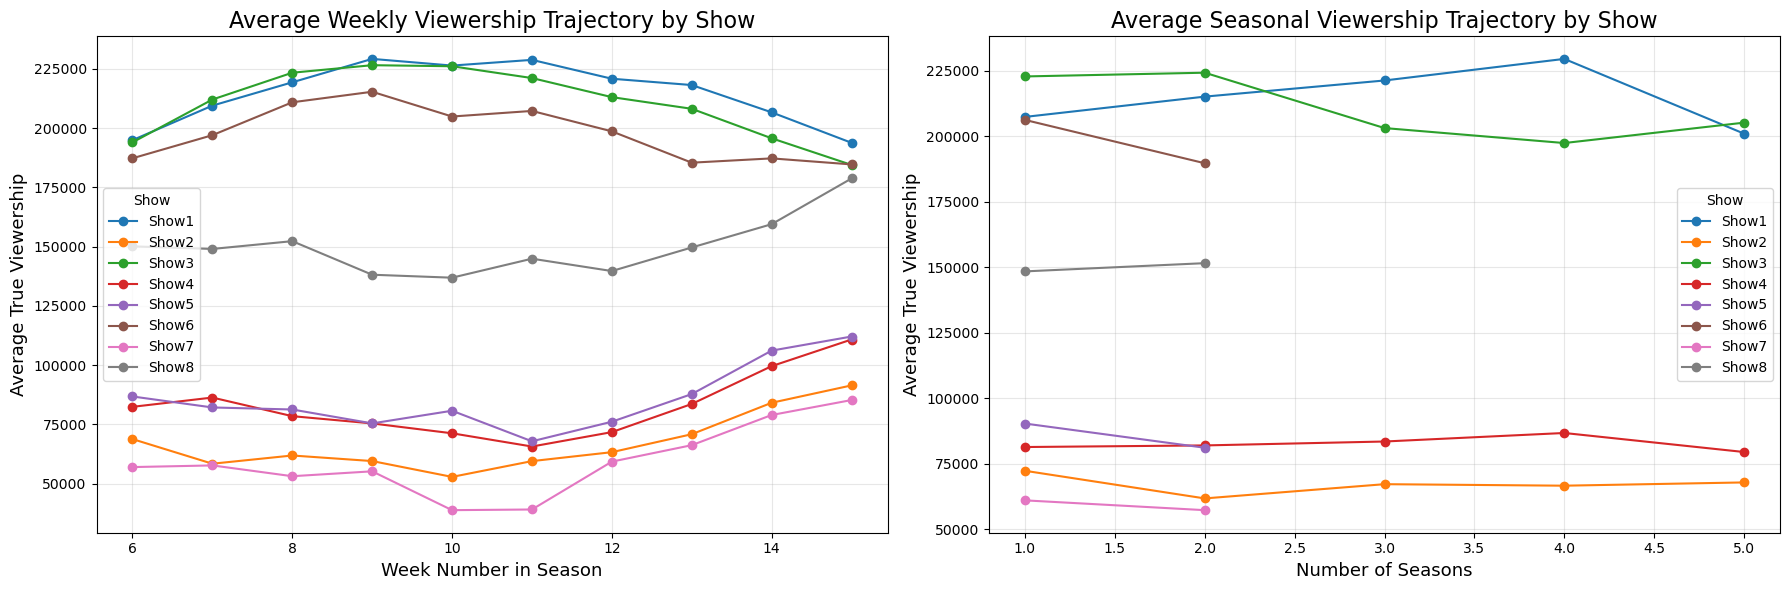

In [31]:
df = df_gold.copy()

df["Total_Spend"] = (
    df["Network_TV_Spend"]
    + df["Cable_TV_Spend"]
    + df["Digital_Spend"]
)

df_week = df[df["Episode_Type"] != "PreLaunch"].copy()

# Average weekly
avg_weekly = (
    df_week.groupby(["Show", "Week_Number"])["True_Viewership"]
           .mean()
           .reset_index()
           .sort_values(["Show", "Week_Number"])
)

# Average seasonal
avg_seasonal = (
    df_week.groupby(["Show", "Season"])["True_Viewership"]
           .mean()
           .reset_index()
           .sort_values(["Show", "Season"])
)

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot 1: Weekly Trajectories
for show, g in avg_weekly.groupby("Show"):
    axes[0].plot(g["Week_Number"], g["True_Viewership"], marker="o", label=show)

axes[0].set_title("Average Weekly Viewership Trajectory by Show")
axes[0].set_xlabel("Week Number in Season")
axes[0].set_ylabel("Average True Viewership")
axes[0].grid(True, alpha=0.3)
axes[0].legend(title="Show")


# Plot 2: Seasonal Trajectories
for show, g in avg_seasonal.groupby("Show"):
    axes[1].plot(g["Season"], g["True_Viewership"], marker="o", label=show)

axes[1].set_title("Average Seasonal Viewership Trajectory by Show")
axes[1].set_xlabel("Number of Seasons")
axes[1].set_ylabel("Average True Viewership")
axes[1].grid(True, alpha=0.3)
axes[1].legend(title="Show")

plt.tight_layout()
plt.show()

- Across weeks, most shows follow a **classic season arc** where they’re strong around the mid–late weeks (9-12) and then soften a bit toward the very end, with Shows 1, 3, and 6 consistently sitting in the top tier.
- Lower-rated shows (5, 7, 8) sit in a separate band well below the big hitters, but even there I can see a **late-season lift** around weeks 13–15 as finales approach.
- Looking across seasons, **Show1 and Show3 stay high and relatively stable**, which is what I’d expect from established flagships. Show6 drifts down after Season 1, suggesting some fatigue.
- Show8 is interesting: it starts as a mid-pack show but **builds over time**, with average viewership creeping up across seasons, which hints that it’s still in a growth phase compared to the others.

#### 2.3 Holiday, Lead-in, and Episode Type Effects on Viewership

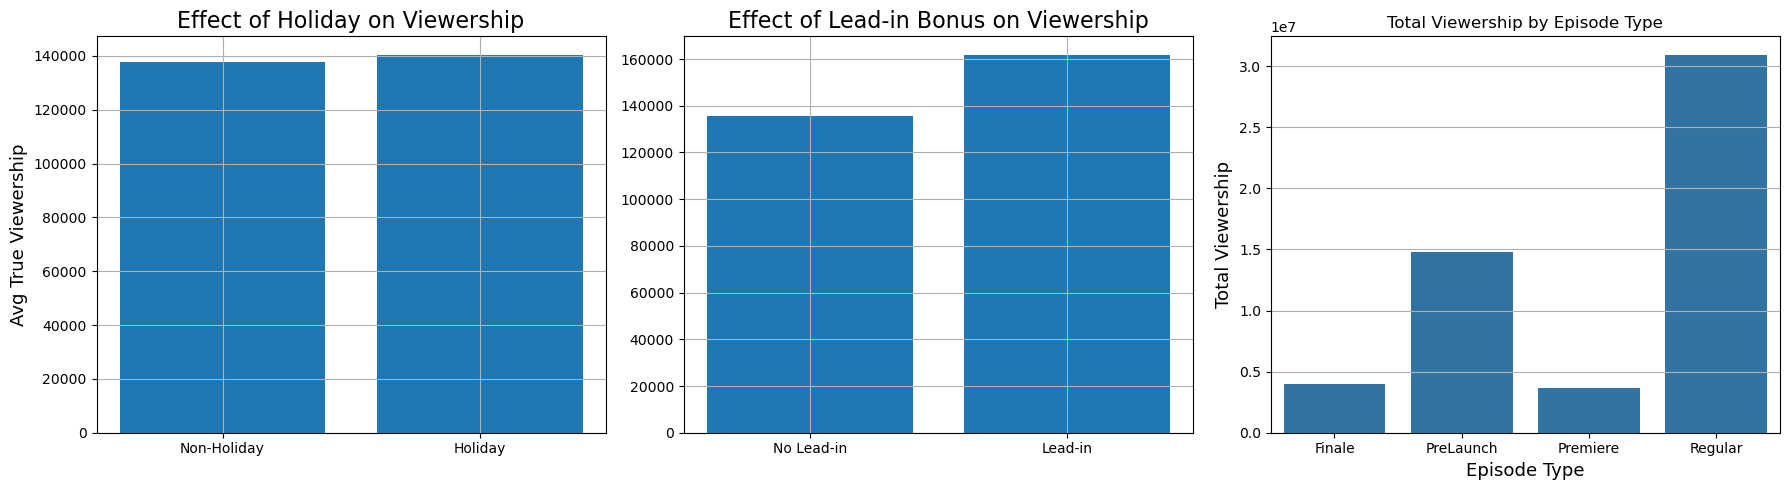

In [33]:
# Holiday aggregation
holiday_agg = (
    df_week.groupby("Holiday")["True_Viewership"]
           .mean()
           .reset_index()
)
holiday_labels = holiday_agg["Holiday"].map({0: "Non-Holiday", 1: "Holiday"})

# Lead-in aggregation
lead_agg = (
    df_week.groupby("LeadIn_Bonus")["True_Viewership"]
           .mean()
           .reset_index()
)
lead_labels = lead_agg["LeadIn_Bonus"].map({0: "No Lead-in", 1: "Lead-in"})

# Episode type aggregation
type_agg = (
    df.groupby("Episode_Type")
      .agg(
          total_viewers=("True_Viewership", "sum"),
          total_revenue=("Revenue", "sum"),
          avg_viewers=("True_Viewership", "mean")
      )
      .reset_index()
)

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=False)

# Plot 1: Holiday
axes[0].bar(holiday_labels, holiday_agg["True_Viewership"])
axes[0].set_title("Effect of Holiday on Viewership")
axes[0].set_ylabel("Avg True Viewership")

# Plot 2: Lead-in
axes[1].bar(lead_labels, lead_agg["True_Viewership"])
axes[1].set_title("Effect of Lead-in Bonus on Viewership")
axes[1].set_ylabel("") 

# Plot 3: Episode Type
sns.barplot(
    data=type_agg,
    x="Episode_Type",
    y="total_viewers",
    ax=axes[2]
)
axes[2].set_title("Total Viewership by Episode Type", fontsize=12)
axes[2].set_xlabel("Episode Type")
axes[2].set_ylabel("Total Viewership")

plt.tight_layout()
plt.show()

- **Holiday vs non-holiday:** average viewership on holidays is very similar (and only slightly higher) than non-holiday weeks, so holidays don’t look like a huge structural driver once everything else is held constant.
- **Lead-in bonus:** episodes with a lead-in clearly sit higher, with average ratings jumping from ~135k to ~160k, so using a strong lead-in slot does seem to give a meaningful boost.
- **Episode-type totals:** most of the total audience comes from **Regular** episodes (there are simply many more of them), with **PreLaunch** contributing a decent chunk and **Premiere/Finale** representing a smaller share of total impressions even though they’re usually the “marquee” nights.

#### 2.4 Marketing Spend vs Revenue (with Show & Episode-Type Level)

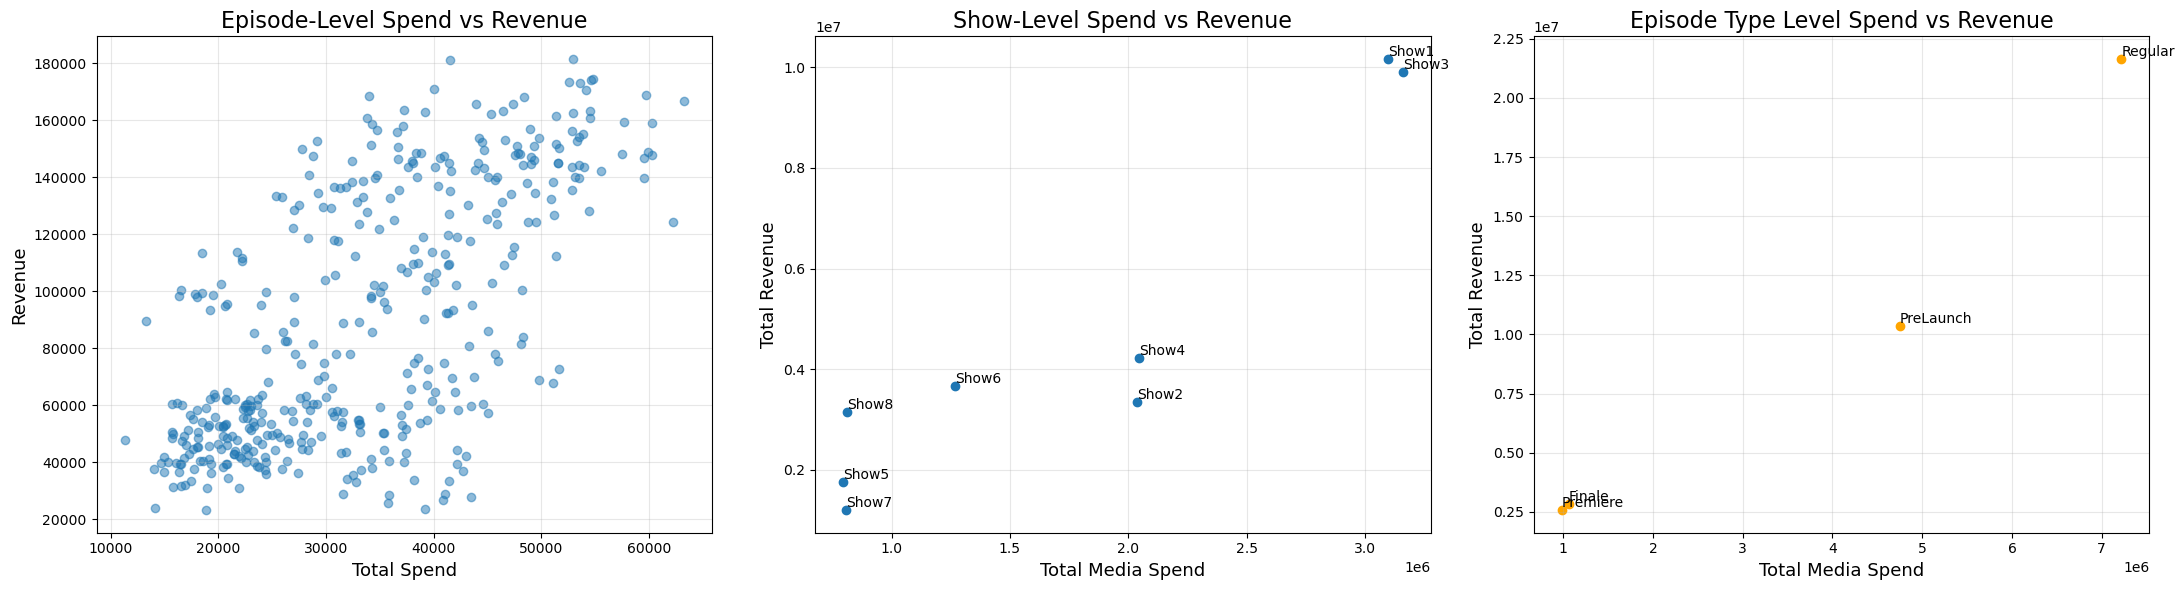

In [35]:
# Aggregations
ep_type_agg = (
    df.groupby("Episode_Type")[["Total_Spend", "Revenue"]]
      .sum()
      .reset_index()
)

show_agg = (
    df.groupby("Show")[["Total_Spend", "Revenue"]]
      .sum()
      .reset_index()
)

fig, axes = plt.subplots(1, 3, figsize=(22, 6))

# 1. Episode-level Spend vs Revenue (raw episodes)
axes[0].scatter(df["Total_Spend"], df["Revenue"], alpha=0.5)
axes[0].set_title("Episode-Level Spend vs Revenue")
axes[0].set_xlabel("Total Spend")
axes[0].set_ylabel("Revenue")
axes[0].grid(True, alpha=0.3)

# 2. Episode-Type-Level Spend vs Revenue (aggregated)
axes[1].scatter(show_agg["Total_Spend"], show_agg["Revenue"])

# Label each point with Episode Type
for _, row in show_agg.iterrows():
    axes[1].text(
        row["Total_Spend"],
        row["Revenue"],
        row["Show"],
        ha="left",
        va="bottom"
    )

axes[1].set_title("Show-Level Spend vs Revenue")
axes[1].set_xlabel("Total Media Spend")
axes[1].set_ylabel("Total Revenue")
axes[1].grid(True, alpha=0.3)

# 3. Episode-Type-Level Spend vs Revenue (duplicate if needed)
axes[2].scatter(ep_type_agg["Total_Spend"], ep_type_agg["Revenue"], color="orange")

for _, row in ep_type_agg.iterrows():
    axes[2].text(
        row["Total_Spend"],
        row["Revenue"],
        row["Episode_Type"],
        ha="left",
        va="bottom"
    )

axes[2].set_title("Episode Type Level Spend vs Revenue")
axes[2].set_xlabel("Total Media Spend")
axes[2].set_ylabel("Total Revenue")
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

There’s a clear upward trend between total spend and revenue, but with a lot of spread at each spend level, some episodes monetize much better than others for the same budget, which screams “context matters” (show, episode type, timing, etc.).
- **Show-level (middle):** Show1 and Show3 are the big engines (highest total spend and revenue), while shows like 2, 4, 6 sit in the middle tier. Show8 is interesting effective as it runs on relatively modest budgets but still delivers solid revenue, so it looks more efficient than some of the mid-pack shows.
- **Episode-type view (right):** most of the money is being made on **Regular** episodes, which get the bulk of media spend and total revenue, **PreLaunch** invests a decent amount and brings in meaningful revenue, while **Premiere** and **Finale** have smaller total budgets and revenue simply because there are fewer of those episodes, even though they’re “important” nights.

#### 2.5 Average Viewership by Week & Month of Year

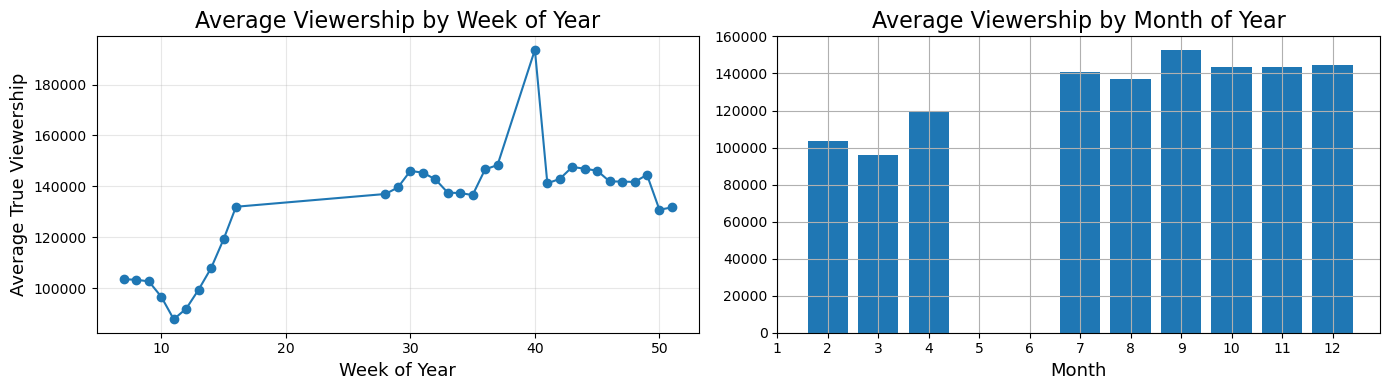

In [37]:
# Week of year
df_week["WeekOfYear"] = df_week["Air_Date"].dt.isocalendar().week.astype(int)
avg_weekofyear = (
    df_week.groupby("WeekOfYear")["True_Viewership"]
           .mean()
           .reset_index()
           .sort_values("WeekOfYear")
)

# Month of year
df_week["Month"] = df_week["Air_Date"].dt.month
avg_month = (
    df_week.groupby("Month")["True_Viewership"]
           .mean()
           .reset_index()
           .sort_values("Month")
)

# Side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharey=False)

# Left: week of year
axes[0].plot(avg_weekofyear["WeekOfYear"],
             avg_weekofyear["True_Viewership"],
             marker="o")
axes[0].set_title("Average Viewership by Week of Year")
axes[0].set_xlabel("Week of Year")
axes[0].set_ylabel("Average True Viewership")
axes[0].grid(True, alpha=0.3)

# Right: month of year
axes[1].bar(avg_month["Month"], avg_month["True_Viewership"])
axes[1].set_title("Average Viewership by Month of Year")
axes[1].set_xlabel("Month")
axes[1].set_xticks(range(1, 13))

plt.tight_layout()
plt.show()

- The **back half of the year (Jul-Dec)** clearly delivers stronger, more stable viewership, so that’s where it makes sense to **stack big launches and higher-impact tentpole campaigns** to ride the natural audience lift.
- The **early months (Feb-Mar)** are softer, which makes them good candidates for **testing new shows, formats, or creative** at lower spend levels before we lean in harder during the high-demand window.
- Knowing that fall spikes (around week ~40) are consistently strong, we can target that period to maximize both ratings and revenue when the audience is naturally most engaged.
- **No shows are aired during Jan, May & June**.

#### 2.6 Channel Spend vs Impressions (Network, Cable, Digital)

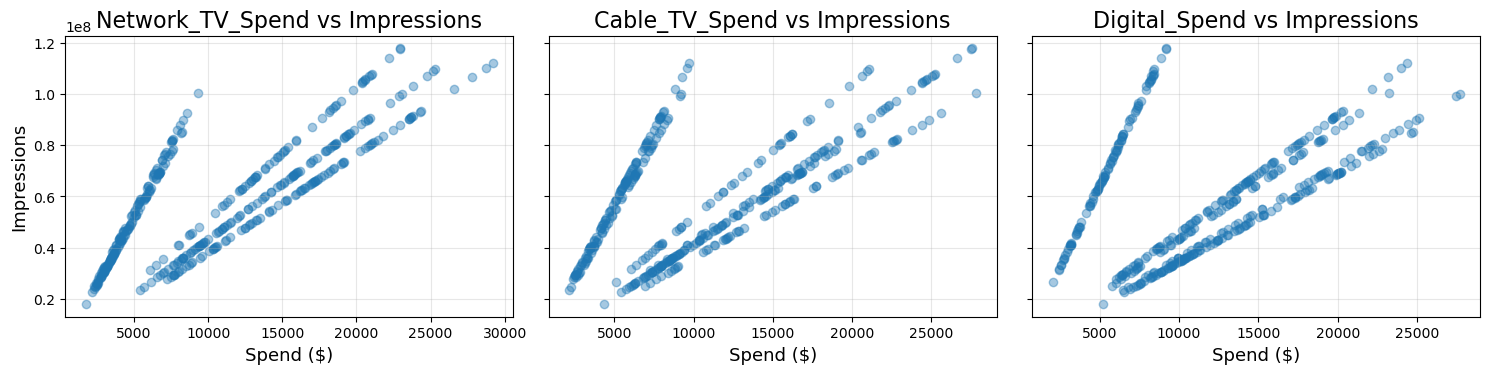

In [39]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

channels = ["Network_TV_Spend", "Cable_TV_Spend", "Digital_Spend"]

for ax, ch in zip(axes, channels):
    ax.scatter(df[ch], df["Impressions"], alpha=0.4)
    ax.set_title(f"{ch} vs Impressions")
    ax.set_xlabel("Spend ($)")
    ax.grid(True, alpha=0.3)

axes[0].set_ylabel("Impressions")

plt.tight_layout()
plt.show()

- All three channels show tight, almost linear relationships between spend and impressions, indicating consistent buying efficiency.  
- Differences in slope across channels suggest that some channels (notably Digital) may deliver more impressions per dollar, hinting at opportunities to rebalance mix toward higher-productivity inventory.

#### 2.7 Marketing Spends Summary

In [41]:
show_summary_df = df_gold.copy()
show_summary_df['Total_Spend'] = show_summary_df['Network_TV_Spend'] + show_summary_df['Cable_TV_Spend'] + show_summary_df['Digital_Spend']

# Aggregate by "campaign" (assume Show = campaign) and channel
show_summary = show_summary_df.groupby('Show', as_index=False).agg({
    'Network_TV_Spend': 'sum',
    'Cable_TV_Spend': 'sum',
    'Digital_Spend': 'sum',
    'Impressions': 'sum',
    'Revenue': 'sum',
    'Total_Spend': 'sum'
})

# Compute overall campaign metrics (Return of Interest/ Cost per impression)
show_summary['ROI'] = show_summary['Revenue'] / show_summary['Total_Spend']
show_summary['CPA'] = show_summary['Total_Spend'] / show_summary['Impressions'] * 1000

show_summary  = show_summary.round(2)

show_summary.sort_values('ROI', ascending=False)

,Show,Network_TV_Spend,Cable_TV_Spend,Digital_Spend,Impressions,Revenue,Total_Spend,ROI,CPA
7,Show8,248937.84,312540.29,251126.63,1457062170,3150256.37,812604.76,3.88,0.56
0,Show1,1052725.22,948018.92,1094936.85,5447333534,10167655.65,3095680.99,3.28,0.57
2,Show3,1069232.58,1065500.58,1023622.79,5649499970,9899449.82,3158355.95,3.13,0.56
5,Show6,536477.55,392416.77,340269.17,2376883662,3667744.50,1269163.49,2.89,0.53
4,Show5,246470.86,212815.96,336051.39,1336781975,1749209.16,795338.20,2.20,0.59
3,Show4,570079.02,721945.12,752285.55,3526360166,4229937.02,2044309.69,2.07,0.58
1,Show2,721765.09,530206.90,783418.03,3527950374,3341822.27,2035390.02,1.64,0.58
6,Show7,124317.86,341690.63,342057.60,1315513850,1196136.37,808066.08,1.48,0.61


- **Show8 is the star** - it isn’t the biggest spender, but it has the **highest ROI (~3.9x)** and very strong revenue per dollar, so it’s the most efficient place to park incremental budget.
- **Show1 and Show3 are the workhorses** - huge revenue and solid ROI in the low 3x range; they justify their large budgets and should be protected in planning.
- **Middle of the pack (Shows 4, 5, 6)** deliver okay ROI (~2–2.9x) but are clear candidates for **creative/targeting optimization** rather than aggressive cuts.
- **Show2 and Show7 sit at the bottom** with ROI <2x, meaning they soak up a lot of media for relatively weaker returns; they’re the first places I’d look for **budget reallocation** if we need to free up money.

### Overall EDA Story

**Overall Scale & Variation**

- Weekly **viewership is all over the place** from ~33k to ~262k, with a median around 108k, so we clearly have weak, average, and breakout episodes in the mix.
- **Revenue moves in step with ratings** (mean ~ **\$89k**, max ~ **\$182k**), which is exactly what we need if we want to translate incremental viewers into dollars later.
- Media budgets are **fairly balanced across Network, Cable, and Digital** (roughly **\$10** - **12k** per channel per week), so no single channel is completely dominating.
- Each channel has a **wide spend range** (~ **\$2k** - **\$29k** per week), which gives the model enough variation to learn response curves and saturation instead of guessing around a fixed level.


**Show & Episode-Type Dynamics**

- Most shows follow a **classic season arc**: mid-late weeks (around 9-12) tend to be stronger, with some softening toward the very end.
- **Show1 and Show3** behave like stable flagships with how they stay high and relatively consistent across seasons; **Show6** shows signs of fatigue after Season 1.
- **Show8 is the interesting grower**: it starts mid-pack but gradually builds an audience over time, suggesting it’s still in a growth phase.
- By episode type, **Regular episodes** carry most of the total audience and revenue (simply because there are many of them), **PreLaunch** contributes a meaningful chunk but perform poorly in revenue, and **Premiere/Finale** nights are important but fewer in count.


**Timing, Calendar & Context**

- **Lead-in bonus matters**: episodes with a strong lead-in sit clearly higher, with average ratings jumping from ~135k to ~160k.
- **Holidays don’t look like a huge structural driver** once everything else is considered – holiday and non-holiday weeks sit in a similar band.
- The **back half of the year (Jul-Dec)** consistently delivers stronger, more stable viewership, especially around the fall spike (week ~40), making it the best window for big launches and tentpole campaigns.
- The **early-year months (Feb-Mar)** are softer, which makes them good candidates for testing new shows or creative at lower spend levels before leaning in during the high-demand window.
- There’s **no airing in months 5 and 6**, which lines up with a natural scheduling gap before the heavier part of the season.


**Spend, Revenue & ROI**

- At the episode level, higher spend generally leads to higher revenue, but there’s a lot of spread where some episodes **monetize much better than others for the same budget**, which reinforces that context (show, type, timing, lead-in) really matters.
- At the show level, **Show1 and Show3 are the big engines**: highest total spend and highest total revenue, with solid ROIs in the low 3x range.
- **Show8 is the efficiency star** – smaller budgets but the best ROI (~3.9x), making it the most attractive spot for incremental budget.
- Mid-tier shows (4, 5, 6) deliver **okay ROI (~2–2.9x)** and are natural targets for creative/targeting optimization rather than immediate cuts.
- **Show2 and Show7 sit at the bottom** with ROI <2x, so they’re the first places I’d look if we need to free up budget for higher-performing shows.

Putting it all together: the EDA confirms that (1) there is plenty of variation in both inputs and outcomes, (2) season structure, calendar timing, and lead-in matter a lot, and (3) not all shows are created equal from an efficiency standpoint. That gives us a strong foundation for MMM – the model isn’t starting from a blank slate but it’s quantifying patterns we already see in the data and turning them into actionable “where to spend next” decisions.

### 3. Feature Engineering

We fit a **marketing mix model (MMM)** on the cleaned Gold dataset (`df_gold`) using **multiple linear regression with Ridge regularization**. The dependent variable is **`True_Viewership`**, which captures weekly episode-level viewership across shows and seasons.

To capture marketing and non-marketing drivers, we engineer the following features:

**Media spend transforms**
  - Raw spends: `Network_TV_Spend`, `Cable_TV_Spend`, `Digital_Spend`
  - **Log transforms** (`log_*`) to capture **diminishing returns**:  
    `log_Network_TV_Spend`, `log_Cable_TV_Spend`, `log_Digital_Spend`.
  - **Adstocked spends** (`Adstock_*`) to model **carryover effects** with geometric decay:  
    `Adstock_Network`, `Adstock_Cable`, `Adstock_Digital`.
  - **Hill transforms** (`Hill_*`) applied to adstocked spends to model **saturation** (plateauing impact at high spend):  
    `Hill_Network`, `Hill_Cable`, `Hill_Digital`.

**Episode structure controls** - Dummy flags for episode type: `Is_Premiere`, `Is_Finale`, `Is_Prelaunch`.

**Time and momentum**
  - `TimeIndex`: global increasing time index to capture slow trends.
  - `Lag_Viewership`: previous episode’s viewership within each show/season to capture **habit/momentum**.

**Channel mix share** Share of each channel within total brand spend: `Share_Network`, `Share_Cable`, `Share_Digital`.

**External controls** - `Holiday` and `LeadIn_Bonus`

**Fixed effects** One-hot encoding for `Show` and `Season` (dropping one level each) to capture **structural differences** between shows and seasons.

In [43]:
# Simple geometric adstock: adstock_t = x_t + decay * adstock_{t-1}
def adstock_series(x: pd.Series, decay: float) -> pd.Series:
    result = []
    prev = 0.0
    for v in x:
        val = v + decay * prev
        result.append(val)
        prev = val
    return pd.Series(result, index=x.index)

# Hill saturation transform: y = x^alpha / (gamma^alpha + x^alpha)
def hill_transform(x: pd.Series, alpha: float = 1.5, gamma: float = 0.5) -> pd.Series:
    x = x.clip(lower=0)
    return (x ** alpha) / (gamma ** alpha + x ** alpha)


def build_mmm_features(df_gold: pd.DataFrame,
                       decay_network: float = 0.5,
                       decay_cable: float = 0.5,
                       decay_digital: float = 0.7,
                       hill_alpha: float = 1.5,
                       hill_gamma: float = 0.5):

    df = df_gold.copy()
    df["Air_Date"] = pd.to_datetime(df["Air_Date"])

    # 1. Sort for lag & adstock
    df = df.sort_values(["Show", "Season", "Air_Date"]).reset_index(drop=True)

    # Episode flags
    df["Is_Premiere"]  = (df["Episode_Type"] == "Premiere").astype(int)
    df["Is_Finale"]    = (df["Episode_Type"] == "Finale").astype(int)
    df["Is_Prelaunch"] = (df["Episode_Type"] == "PreLaunch").astype(int)

    # 2. Sort again for time index (kept exactly as original)
    df = df.sort_values("Air_Date").reset_index(drop=True)
    df["TimeIndex"] = np.arange(len(df))

    # Lag viewership
    df["Lag_Viewership"] = (
        df.sort_values(["Show", "Season", "Air_Date"])
          .groupby(["Show", "Season"])["True_Viewership"]
          .shift(1)
    )
    df["Lag_Viewership"] = (
        df.groupby(["Show", "Season"])["Lag_Viewership"]
          .bfill()
          .fillna(df["True_Viewership"].median())
    )

    # Total spend + Share of Voice
    df["Total_Spend"] = df["Network_TV_Spend"] + df["Cable_TV_Spend"] + df["Digital_Spend"]
    df["Total_Spend_safe"] = df["Total_Spend"].replace(0, np.nan)

    df["Share_Network"] = df["Network_TV_Spend"] / df["Total_Spend_safe"]
    df["Share_Cable"]   = df["Cable_TV_Spend"] / df["Total_Spend_safe"]
    df["Share_Digital"] = df["Digital_Spend"]  / df["Total_Spend_safe"]

    df[["Share_Network", "Share_Cable", "Share_Digital"]] = \
        df[["Share_Network", "Share_Cable", "Share_Digital"]].fillna(0)

    # Log media
    for col in ["Network_TV_Spend", "Cable_TV_Spend", "Digital_Spend"]:
        df[f"log_{col}"] = np.log1p(df[col])

    # Adstock per channel (CRITICAL: group_keys=False preserved)
    df["Adstock_Network"] = (
        df.groupby(["Show", "Season"], group_keys=False)["Network_TV_Spend"]
          .apply(lambda s: adstock_series(s, decay_network))
    )
    df["Adstock_Cable"] = (
        df.groupby(["Show", "Season"], group_keys=False)["Cable_TV_Spend"]
          .apply(lambda s: adstock_series(s, decay_cable))
    )
    df["Adstock_Digital"] = (
        df.groupby(["Show", "Season"], group_keys=False)["Digital_Spend"]
          .apply(lambda s: adstock_series(s, decay_digital))
    )

    # Hill transforms
    df["Hill_Network"] = hill_transform(df["Adstock_Network"], alpha=hill_alpha, gamma=hill_gamma)
    df["Hill_Cable"]   = hill_transform(df["Adstock_Cable"],   alpha=hill_alpha, gamma=hill_gamma)
    df["Hill_Digital"] = hill_transform(df["Adstock_Digital"], alpha=hill_alpha, gamma=hill_gamma)

    # Fixed effects (dummies)
    df = pd.get_dummies(df, columns=["Show", "Season"], drop_first=True)

    # Feature sets
    log_cols = ["log_Network_TV_Spend", "log_Cable_TV_Spend", "log_Digital_Spend"]
    adstock_cols = ["Adstock_Network", "Adstock_Cable", "Adstock_Digital"]
    hill_cols = ["Hill_Network", "Hill_Cable", "Hill_Digital"]

    control_cols = [
        "Is_Premiere", "Is_Finale", "Is_Prelaunch",
        "Lag_Viewership", "TimeIndex",
        "Share_Network", "Share_Cable", "Share_Digital",
        "Holiday", "LeadIn_Bonus"
    ]

    fixed_effect_cols = [c for c in df.columns if c.startswith("Show_")] + \
                        [c for c in df.columns if c.startswith("Season_")]

    feature_sets = {
        "model_A_log": log_cols + control_cols + fixed_effect_cols,
        "model_B_adstock": log_cols + adstock_cols + control_cols + fixed_effect_cols,
        "model_C_hill": hill_cols + control_cols + fixed_effect_cols,
    }

    # Fill NaNs in feature columns
    for cols in feature_sets.values():
        df[cols] = df[cols].fillna(0)

    return df, feature_sets


### 4. Modelling

Using these features, we define three model specifications:

- **Model A – Ridge (log)**  
  `log_*` media features + controls + fixed effects  
  → Baseline model with **diminishing returns** only.

- **Model B – Ridge (log + adstock)**  
  `log_*` + `Adstock_*` + controls + fixed effects  
  → Captures **diminishing returns + carryover**.

- **Model C – Ridge (Hill Saturation)**  
  `Hill_*` + controls + fixed effects  
  → Captures **carryover + saturation**.

We use a **chronological train/test split** (first ~80% of time as train, last ~20% as test) to respect the time-series nature of the data.

In [45]:
def split_train_test(df, test_frac=0.2):
    df = df.sort_values("Air_Date").reset_index(drop=True)
    n_test = int(test_frac * len(df))
    train = df.iloc[:-n_test].copy()
    test  = df.iloc[-n_test:].copy()
    return train, test

def compute_vif(df, feature_list):
    X = df[feature_list].astype(float).values
    vif_df = pd.DataFrame({
        "feature": feature_list,
        "VIF": [variance_inflation_factor(X, i) for i in range(X.shape[1])]
    })
    return vif_df


def evaluate_ridge_model(name, X_tr, y_tr, X_te, y_te, alpha=50.0):
    model = Ridge(alpha=alpha)
    model.fit(X_tr, y_tr)

    y_tr_pred = model.predict(X_tr)
    y_te_pred = model.predict(X_te)

    r2_tr = r2_score(y_tr, y_tr_pred)
    r2_te = r2_score(y_te, y_te_pred)
    rmse_te = np.sqrt(mean_squared_error(y_te, y_te_pred))

    print(f"\n=== {name} (alpha={alpha}) ===")
    print(f"R² train: {r2_tr:0.3f}")
    print(f"R² test : {r2_te:0.3f}")
    print(f"RMSE test: {rmse_te:0.1f}")

    return r2_tr, r2_te, rmse_te, model

#### 4.1 Split Data and Detect Multicollinearity

We use **Variance Inflation Factor (VIF)** to diagnose multicollinearity:

- When we compute VIF on a mixed set of `log_*`, `Adstock_*`, and `Hill_*` features, we see **extremely high VIF values**, because these are monotonic transformations of the same underlying spends.
- To better understand multicollinearity, we compute VIF **per model spec**, using only the relevant media features for that model:
  - Model A: VIF on `log_*` + `TimeIndex`
  - Model B: VIF on `log_*` + `Adstock_*` + `TimeIndex`
  - Model C: VIF on `Hill_*` + `TimeIndex`

In [47]:
# FEATURE ENGINEERING 
df_mmm, feature_sets = build_mmm_features(df_gold)

# TRAIN/TEST SPLIT
train, test = split_train_test(df_mmm)

y_train = train["True_Viewership"].values
y_test  = test["True_Viewership"].values

# MULTICOLLINEARITY CHECK (VIF)

feat_A = feature_sets["model_A_log"]
feat_B = feature_sets["model_B_adstock"]
feat_C = feature_sets["model_C_hill"]

vif_A_features = [c for c in feat_A if c.startswith("log_")] + ["TimeIndex"]
vif_B_features = [c for c in feat_B if c.startswith("log_") or c.startswith("Adstock_")] + ["TimeIndex"]
vif_C_features = [c for c in feat_C if c.startswith("Hill_")] + ["TimeIndex"]

print("VIF – Model A (log media only):")
vif_A = compute_vif(train, vif_A_features)
display(vif_A.round(2))

print("\nVIF – Model B (log + adstock):")
vif_B = compute_vif(train, vif_B_features)
display(vif_B.round(2))

print("\nVIF – Model C (Hill):")
vif_C = compute_vif(train, vif_C_features)
display(vif_C.round(2))

VIF – Model A (log media only):


,feature,VIF
0,log_Network_TV_Spend,168.36
1,log_Cable_TV_Spend,149.92
2,log_Digital_Spend,197.08
3,TimeIndex,4.13



VIF – Model B (log + adstock):


,feature,VIF
0,log_Network_TV_Spend,1426.78
1,log_Cable_TV_Spend,1217.63
2,log_Digital_Spend,1245.10
3,Adstock_Network,39.99
4,Adstock_Cable,26.34
5,Adstock_Digital,24.26
6,TimeIndex,4.45



VIF – Model C (Hill):


,feature,VIF
0,Hill_Network,1.085205e+13
1,Hill_Cable,1.217189e+13
2,Hill_Digital,1.849528e+13
3,TimeIndex,4.150000e+00


We observe:

- Model A’s log media features have moderate to high VIF, reflecting correlation between channels (they often move together).
- Model B and especially Model C show **very high VIF** for their transformed media features, confirming **strong multicollinearity**.

Because of this, we **rely on a simpler set of features (e.g., logs only) for interpretation**, and treat the richer models (with adstock/Hill) primarily as **predictive tools** rather than deeply interpretable causal models.

#### 4.2 Modeling the three varients of Ridge MMM

In [49]:
results = []

# ---- Model A ----
feat_A = feature_sets["model_A_log"]
X_train_A = train[feat_A].values
X_test_A  = test[feat_A].values

r2tr_A, r2te_A, rmse_A, modelA = evaluate_ridge_model(
    "Model A – Ridge (log + controls)",
    X_train_A, y_train, X_test_A, y_test,
    alpha=50.0
)
results.append(["Model A – Ridge (log)", "log + controls + FE", r2tr_A, r2te_A, rmse_A])

# ---- Model B ----
feat_B = feature_sets["model_B_adstock"]
X_train_B = train[feat_B].values
X_test_B  = test[feat_B].values

r2tr_B, r2te_B, rmse_B, modelB = evaluate_ridge_model(
    "Model B – Ridge (log + adstock + controls)",
    X_train_B, y_train, X_test_B, y_test,
    alpha=40.0
)
results.append(["Model B – Ridge (adstock)", "log + adstock + controls + FE", r2tr_B, r2te_B, rmse_B])

# ---- Model C ----
feat_C = feature_sets["model_C_hill"]
X_train_C = train[feat_C].values
X_test_C  = test[feat_C].values

r2tr_C, r2te_C, rmse_C, modelC = evaluate_ridge_model(
    "Model C – Ridge (Hill + controls)",
    X_train_C, y_train, X_test_C, y_test,
    alpha=25.0
)
results.append(["Model C – Ridge (Hill)", "Hill(adstock) + controls + FE", r2tr_C, r2te_C, rmse_C])

# Summary table
model_summary = pd.DataFrame(results,
    columns=["Model", "Features", "R2_train", "R2_test", "RMSE_test"]
)

display(model_summary.sort_values("R2_test", ascending=False))


=== Model A – Ridge (log + controls) (alpha=50.0) ===
R² train: 0.971
R² test : 0.969
RMSE test: 10641.5

=== Model B – Ridge (log + adstock + controls) (alpha=40.0) ===
R² train: 0.974
R² test : 0.969
RMSE test: 10666.4

=== Model C – Ridge (Hill + controls) (alpha=25.0) ===
R² train: 0.962
R² test : 0.958
RMSE test: 12352.9


,Model,Features,R2_train,R2_test,RMSE_test
0,Model A – Ridge (log),log + controls + FE,0.970990,0.969019,10641.524889
1,Model B – Ridge (adstock),log + adstock + controls + FE,0.973884,0.968874,10666.410172
2,Model C – Ridge (Hill),Hill(adstock) + controls + FE,0.961844,0.958253,12352.903484


Across all three Ridge MMMs, the models fit extremely well:

- **Model A (log only)**: R²_train = 0.971, R²_test = 0.969, RMSE_test ≈ 10,642 viewers  
- **Model B (log + adstock)**: R²_train = 0.974, R²_test = 0.969, RMSE_test ≈ 10,666 viewers  
- **Model C (Hill Saturation)**: R²_train = 0.962, R²_test = 0.958, RMSE_test ≈ 12,353 viewers  

That is, all models explain ~**96-97%** of the variance in weekly viewership, with Model A and B clearly performing best.

#### 4.3 Coefficient Tables & OLS Model for Interpretation

For **interpretation**, we focus on:

1. The **Ridge models’ largest coefficients** (by absolute value), and  
2. The **simpler OLS model**, which gives p-values and confidence intervals.

In [51]:
# COEFFICIENT TABLES FOR INTERPRETATION (RIDGE)
coef_A = pd.DataFrame({
    "feature": feat_A,
    "coef": modelA.coef_
}).sort_values("coef", key=np.abs, ascending=False)

print("\nTop media/control coefficients – Model A:")
display(coef_A.head(20))

coef_B = pd.DataFrame({
    "feature": feat_B,
    "coef": modelB.coef_
}).sort_values("coef", key=np.abs, ascending=False)

# print("\nTop media/control coefficients – Model B:")
# display(coef_B.head(20))


Top media/control coefficients – Model A:


,feature,coef
0,log_Network_TV_Spend,5663.928982
1,log_Cable_TV_Spend,5328.813042
2,log_Digital_Spend,4137.688981
13,Show_Show2,-2523.119293
15,Show_Show4,-1490.820296
3,Is_Premiere,1018.534563
18,Show_Show7,-1015.010736
12,LeadIn_Bonus,-975.536188
4,Is_Finale,-959.438442
19,Show_Show8,846.507380


In [53]:
# OLS MODEL FOR SIGNIFICANCE
interpret_features = [
    "log_Network_TV_Spend",
    "log_Cable_TV_Spend",
    "log_Digital_Spend",
    "Is_Premiere", "Is_Finale", "Is_Prelaunch",
    "Lag_Viewership",
    "Holiday", "LeadIn_Bonus",
    "TimeIndex",
]

X_ols = sm.add_constant(train[interpret_features])
ols_model = sm.OLS(y_train, X_ols).fit()

print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                     1128.
Date:                Wed, 19 Nov 2025   Prob (F-statistic):          1.39e-245
Time:                        00:06:04   Log-Likelihood:                -3591.9
No. Observations:                 336   AIC:                             7206.
Df Residuals:                     325   BIC:                             7248.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 -2.05e+05 

### 5. Interpretation

#### Media channels (Network, Cable, Digital)

From **Model A – Ridge (log)**:

- `log_Network_TV_Spend` ≈ **+5664**
- `log_Cable_TV_Spend` ≈ **+5329**
- `log_Digital_Spend` ≈ **+4138**

All three are positive and relatively large compared to most controls, suggesting that **increasing media spend is associated with higher viewership**, with **Network and Cable TV slightly stronger than Digital** in this specification.

In the **OLS model**, these same log media variables are all **highly significant**:

- `log_Network_TV_Spend`: coef ≈ **+8513**, t ≈ 8.0, **p < 0.001**
- `log_Cable_TV_Spend`: coef ≈ **+9013**, t ≈ 8.0, **p < 0.001**
- `log_Digital_Spend`: coef ≈ **+6845**, t ≈ 5.7, **p < 0.001**

Business interpretation:

- All three channels **contribute meaningfully to driving viewership**, with TV (Network + Cable) showing slightly stronger impact.
- Because these are **log-transformed spends**, the effect is consistent with **diminishing returns**: moving from very low to moderate spend has a stronger marginal effect than moving from already-high to even-higher spend.

In **Model B – Ridge (log + adstock)**, the same pattern holds: the largest channel-related coefficients are still on `log_*` media, with `log_Digital_Spend` and `log_Cable_TV_Spend` positive and large, and `log_Network_TV_Spend` still clearly positive. Adstocked terms matter for prediction but are much smaller in magnitude than the show/season and episode-type dummies, which is why we use the simpler OLS spec for clean interpretation.

#### Episode structure and schedule

Episode-type flags show up in Ridge models with meaningful magnitude, but in OLS they are **not consistently statistically significant**:

In **Model A – Ridge**:
  - `Is_Premiere` ≈ **+1019**
  - `Is_Finale` ≈ **−959**
  - `Is_Prelaunch` ≈ **+715**

  This suggests premiers and prelaunch episodes tend to get higher viewership, while finales can be slightly lower once all other factors and fixed effects are controlled for.

- In **OLS**:
  - `Is_Premiere`: coef ≈ +2673, **p ≈ 0.29** (not significant)
  - `Is_Finale`: coef ≈ −4534, **p ≈ 0.089** (borderline)
  - `Is_Prelaunch`: coef ≈ −451, **p ≈ 0.76** (not significant)

Business takeaway:

- Structurally, **premiere/finale episodes do behave differently**, but once you control for media, lag, and show/season fixed effects, the remaining incremental effect is **noisy** in this dataset.
- It still makes intuitive sense to **cluster spend around key episodes**, but the model suggests their incremental impact is already partially captured via the show/season and lagged viewership effects.

#### Momentum & context

The **strongest and cleanest predictor in OLS** is:

- `Lag_Viewership`: coef ≈ **0.892**, t ≈ 67.3, **p < 0.001**

Interpretation:

- For every additional 1 viewer in the previous episode, the current episode gains roughly **0.89 viewers**, holding media and other controls constant.
- This confirms a strong **habit / momentum effect**: once a show has built an audience, it tends to retain a large fraction of that audience week-over-week.

Other controls:

- `Holiday`, `LeadIn_Bonus`, and `TimeIndex` are **not statistically significant** in OLS (p ≫ 0.05), although in Ridge they still get non-trivial coefficients (e.g., `LeadIn_Bonus` is negative and fairly large in absolute value in multiple models). This suggests:
  - They may have **some explanatory power**, but
  - Their effects are relatively **small and unstable** once all other variables are included.

Overall:  
The **combination of strong, significant log media coefficients + very strong lagged viewership** paints a sensible picture: **Media Spend (especially TV) drives reach and tune-in, while existing audience momentum explains a large share of week-to-week variation**

---

#### 5.1 Challenges and limitations

**Multicollinearity between features**  
  Log, adstock, Hill, and share-of-spend are all transformations of the same underlying media spends. This creates strong multicollinearity (high VIF, large condition number in OLS), so individual coefficients should be read as **directional**, not exact causal effects.

**Heuristic adstock / saturation choices**  
  Decay and Hill parameters are **assumed**, not estimated. Model B (log + adstock) performs almost the same as Model A, and Model C (Hill) is slightly worse, suggesting our chosen parameters are not yet optimized.

**Heavy show/season fixed effects**  
  Large **Show_** and **Season_** coefficients show that structural differences between shows explain a lot of variation. This improves fit, but also means some channel patterns may be partly absorbed into these fixed effects.

Overall, the model is **predictively strong and directionally sensible**, but exact per-channel impact and ROI should be interpreted with caution.

---

#### 5.2. Recommended next steps

**Simplify features for interpretation**  
  For business storytelling, use a cleaner spec (e.g., **log media + core controls**) and avoid stacking log, adstock, Hill, and share-of-spend all together.

**Tune parameters or use Industry Standard Bayesian MMMs**  
  Run a simple **grid search** or move to a **Bayesian MMM** to learn decay and Hill parameters from the data, instead of fixing them by hand.

**Refine granularity if needed**  
  If time permits, explore separate or stratified models (e.g., by show cluster or episode type) to see whether certain shows or tentpoles respond differently to media.

---

### 7. Simulation: +20% Digital spend during the test period (Model A)

Using the fitted **Model A - Ridge (log + controls + fixed effects)**, we simulate the impact of a **+20% increase in Digital spend** over the **test period**, holding Network and Cable spends constant.

Steps:

1. Use the existing `df_mmm` with all engineered features and the fitted `modelA` on `feat_A`.
2. Define the **simulation period** as the same date range as our test set.
3. Create a **baseline** prediction using the original data.
4. Create a **scenario** copy where, within the simulation period:
   - `Digital_Spend` is increased by **20%**,
   - `Total_Spend`, `Total_Spend_safe`, `Share_*`, and `log_Digital_Spend` are recomputed.
5. Use Model A to predict viewers under both baseline and scenario.
6. Compare **total predicted viewers** over the simulation period and calculate the **lift**.
7. Plot **Actual vs Predicted (baseline vs +20% Digital)** for the simulation window.

This gives a concrete estimate of how much incremental viewership the model expects from a 20% Digital spend increase, given the current media mix and schedule.

Simulation period: 2024-09-12 to 2025-04-20, rows: 84

Total baseline predicted viewers (period): 10,267,711
Total scenario predicted viewers  (period): 10,329,778
Predicted viewer lift from +20% digital:   62,067
Estimated revenue per viewer: $0.7009
Predicted viewer lift: 62,067
Predicted revenue lift: $43,501.91
Extra digital spend: $208,469.70
ROI (incremental revenue / extra digital): 0.21x


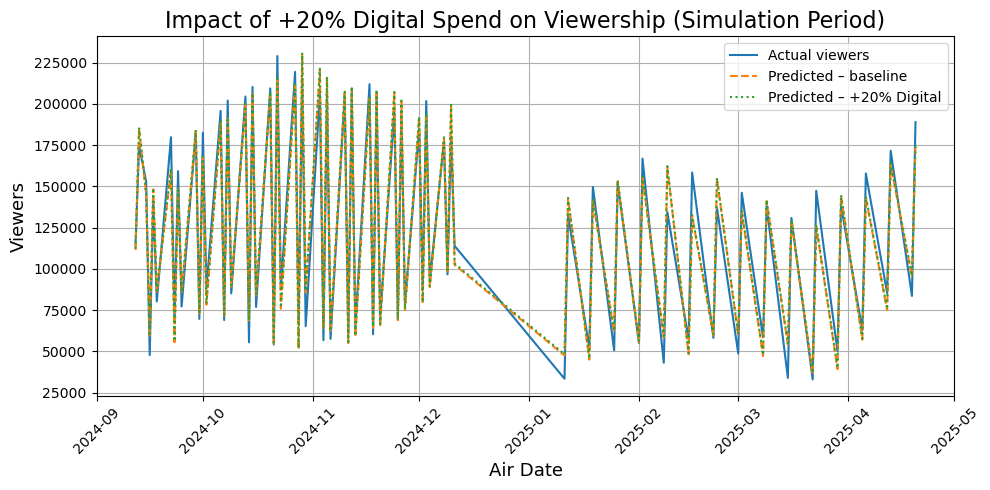

In [57]:
df_sim = df_mmm.sort_values("Air_Date").reset_index(drop=True)

# Define simulation period as the test set window
sim_start = test["Air_Date"].min()
sim_end   = test["Air_Date"].max()

sim_mask = (df_sim["Air_Date"] >= sim_start) & (df_sim["Air_Date"] <= sim_end)

print(f"Simulation period: {sim_start.date()} to {sim_end.date()}, rows: {sim_mask.sum()}")

# Baseline predictions (no change in spend)
X_baseline = df_sim[feat_A].values
y_pred_baseline = modelA.predict(X_baseline)

# Scenario: +20% Digital spend in simulation period
df_scen = df_sim.copy()

# Increase Digital spend by 20% in the simulation period
df_scen.loc[sim_mask, "Digital_Spend"] *= 1.20

# Recompute Total_Spend, Total_Spend_safe, and share-of-channel mix for the period
spend_cols = ["Network_TV_Spend", "Cable_TV_Spend", "Digital_Spend"]

df_scen.loc[sim_mask, "Total_Spend"] = df_scen.loc[sim_mask, spend_cols].sum(axis=1)
df_scen.loc[sim_mask, "Total_Spend_safe"] = df_scen.loc[sim_mask, "Total_Spend"].replace(0, np.nan)

df_scen.loc[sim_mask, "Share_Network"] = (
    df_scen.loc[sim_mask, "Network_TV_Spend"] / df_scen.loc[sim_mask, "Total_Spend_safe"]
)
df_scen.loc[sim_mask, "Share_Cable"] = (
    df_scen.loc[sim_mask, "Cable_TV_Spend"] / df_scen.loc[sim_mask, "Total_Spend_safe"]
)
df_scen.loc[sim_mask, "Share_Digital"] = (
    df_scen.loc[sim_mask, "Digital_Spend"] / df_scen.loc[sim_mask, "Total_Spend_safe"]
)

df_scen.loc[sim_mask, ["Share_Network", "Share_Cable", "Share_Digital"]] = \
    df_scen.loc[sim_mask, ["Share_Network", "Share_Cable", "Share_Digital"]].fillna(0)

# Recompute log(Digital_Spend) for the period (Network/Cable logs unchanged)
df_scen.loc[sim_mask, "log_Digital_Spend"] = np.log1p(df_scen.loc[sim_mask, "Digital_Spend"])

# Scenario predictions
X_scenario = df_scen[feat_A].values
y_pred_scenario = modelA.predict(X_scenario)

# Aggregate lift over the simulation period
baseline_total = y_pred_baseline[sim_mask].sum()
scenario_total = y_pred_scenario[sim_mask].sum()
lift = scenario_total - baseline_total

print(f"\nTotal baseline predicted viewers (period): {baseline_total:,.0f}")
print(f"Total scenario predicted viewers  (period): {scenario_total:,.0f}")
print(f"Predicted viewer lift from +20% digital:   {lift:,.0f}")

# Build plotting dataframe for the simulation window
sim_plot = df_sim.loc[sim_mask, ["Air_Date", "True_Viewership"]].copy()
sim_plot["Pred_Baseline"] = y_pred_baseline[sim_mask]
sim_plot["Pred_Scenario"] = y_pred_scenario[sim_mask]
rev_per_viewer = 0.7008911444379781

viewer_lift = (y_pred_scenario[sim_mask] - y_pred_baseline[sim_mask]).sum()
rev_lift = viewer_lift * rev_per_viewer

# Extra Digital spend over the simulation period
baseline_digital = df_sim.loc[sim_mask, "Digital_Spend"].sum()
scenario_digital = df_scen.loc[sim_mask, "Digital_Spend"].sum()
extra_digital_spend = scenario_digital - baseline_digital  # should be ~20% of baseline_digital

# ROI = incremental revenue / extra digital
roi = rev_lift / extra_digital_spend if extra_digital_spend != 0 else np.nan

print(f"Estimated revenue per viewer: ${rev_per_viewer:0.4f}")
print(f"Predicted viewer lift: {viewer_lift:,.0f}")
print(f"Predicted revenue lift: ${rev_lift:,.2f}")
print(f"Extra digital spend: ${extra_digital_spend:,.2f}")
print(f"ROI (incremental revenue / extra digital): {roi:0.2f}x")

# 8. Plot Actual vs Predicted (baseline vs +20% digital)
plt.figure(figsize=(10, 5))
plt.plot(sim_plot["Air_Date"], sim_plot["True_Viewership"], label="Actual viewers")
plt.plot(sim_plot["Air_Date"], sim_plot["Pred_Baseline"], label="Predicted – baseline", linestyle="--")
plt.plot(sim_plot["Air_Date"], sim_plot["Pred_Scenario"], label="Predicted – +20% Digital", linestyle=":")

plt.xlabel("Air Date")
plt.ylabel("Viewers")
plt.title("Impact of +20% Digital Spend on Viewership (Simulation Period)")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

For the test-period window (2024-09-12 to 2025-04-20, 84 episodes), increasing **Digital spend by 20%** while holding Network and Cable constant leads to:

- **Baseline predicted viewers:** 10,267,711  
- **Scenario predicted viewers (+20% Digital):** 10,329,778  
- **Predicted lift:** **+62,067 viewers** (≈ **+0.6%** lift vs baseline)

On the plot, the **baseline** and **+20% Digital** lines almost overlap, with the scenario line sitting slightly above the baseline. This tells us:

- The model does see **Digital as a positive driver** of viewership.
- However, relative to the overall audience size, a 20% bump in Digital spend only produces a **modest incremental lift (0.21x) in revenue**, which is consistent with Digital acting more as a **supporting channel** rather than the main reach driver (that role is primarily played by Network and Cable TV in this model).

---

### 8. Optimized media spend allocation to maximize revenue

In [59]:
# Grid search optimization of media allocation

# We assume these already exist from previous cells:
# df_mmm, modelA, feat_A, sim_mask, rev_per_viewer

df_base = df_mmm.sort_values("Air_Date").reset_index(drop=True)
spend_cols = ["Network_TV_Spend", "Cable_TV_Spend", "Digital_Spend"]

# Optimization window (same as your test / simulation period)
opt_mask = sim_mask

# Baseline predictions in that window
X_base = df_base[feat_A].values
y_pred_base = modelA.predict(X_base)
baseline_total_viewers = y_pred_base[opt_mask].sum()

print(f"Baseline predicted viewers (opt period): {baseline_total_viewers:,.0f}")

# Total spend per row (keep this fixed)
B = df_base.loc[opt_mask, spend_cols].sum(axis=1)

# Grid of candidate shares (step size controls how coarse/fine the search is)
share_grid = np.linspace(0.05, 0.90, 18)  # 5% to 90% in ~5% steps

best_viewers = -np.inf
best_shares = None

for sN in share_grid:
    for sC in share_grid:
        sD = 1.0 - sN - sC
        # Shares must be between 0 and 1, and Digital at least non-negative
        if sD < 0 or sD > 1:
            continue

        # Copy baseline
        df_scen = df_base.copy()

        # Apply allocation in optimization window
        df_scen.loc[opt_mask, "Network_TV_Spend"] = B * sN
        df_scen.loc[opt_mask, "Cable_TV_Spend"]   = B * sC
        df_scen.loc[opt_mask, "Digital_Spend"]    = B * sD

        # Recompute spend-based features
        df_scen.loc[opt_mask, "Total_Spend"] = df_scen.loc[opt_mask, spend_cols].sum(axis=1)
        df_scen.loc[opt_mask, "Total_Spend_safe"] = df_scen.loc[opt_mask, "Total_Spend"].replace(0, np.nan)

        df_scen.loc[opt_mask, "Share_Network"] = (
            df_scen.loc[opt_mask, "Network_TV_Spend"] / df_scen.loc[opt_mask, "Total_Spend_safe"]
        )
        df_scen.loc[opt_mask, "Share_Cable"] = (
            df_scen.loc[opt_mask, "Cable_TV_Spend"] / df_scen.loc[opt_mask, "Total_Spend_safe"]
        )
        df_scen.loc[opt_mask, "Share_Digital"] = (
            df_scen.loc[opt_mask, "Digital_Spend"] / df_scen.loc[opt_mask, "Total_Spend_safe"]
        )

        df_scen.loc[opt_mask, ["Share_Network", "Share_Cable", "Share_Digital"]] = \
            df_scen.loc[opt_mask, ["Share_Network", "Share_Cable", "Share_Digital"]].fillna(0)

        # Recompute log media
        df_scen.loc[opt_mask, "log_Network_TV_Spend"] = np.log1p(df_scen.loc[opt_mask, "Network_TV_Spend"])
        df_scen.loc[opt_mask, "log_Cable_TV_Spend"]   = np.log1p(df_scen.loc[opt_mask, "Cable_TV_Spend"])
        df_scen.loc[opt_mask, "log_Digital_Spend"]    = np.log1p(df_scen.loc[opt_mask, "Digital_Spend"])

        # Predict with Model A (Ridge)
        X_scen = df_scen[feat_A].values
        y_pred_scen = modelA.predict(X_scen)
        scen_total_viewers = y_pred_scen[opt_mask].sum()

        if scen_total_viewers > best_viewers:
            best_viewers = scen_total_viewers
            best_shares = (sN, sC, sD)

# Report best allocation
sN_best, sC_best, sD_best = best_shares
viewer_lift = best_viewers - baseline_total_viewers
rev_lift = viewer_lift * rev_per_viewer

print("\n=== Optimal allocation (grid search) ===")
print(f"Best Network share: {sN_best:.3f} (~{sN_best*100:.1f}%)")
print(f"Best Cable share  : {sC_best:.3f} (~{sC_best*100:.1f}%)")
print(f"Best Digital share: {sD_best:.3f} (~{sD_best*100:.1f}%)")

print(f"\nOptimal predicted viewers (opt period): {best_viewers:,.0f}")
print(f"Viewer lift vs baseline: {viewer_lift:,.0f}")
print(f"Predicted revenue lift: ${rev_lift:,.2f}")
print("Total media spend is unchanged (we only reallocated budget).")

Baseline predicted viewers (opt period): 10,267,711

=== Optimal allocation (grid search) ===
Best Network share: 0.400 (~40.0%)
Best Cable share  : 0.350 (~35.0%)
Best Digital share: 0.250 (~25.0%)

Optimal predicted viewers (opt period): 10,436,004
Viewer lift vs baseline: 168,293
Predicted revenue lift: $117,954.95
Total media spend is unchanged (we only reallocated budget).


Under the constraint Network + Cable + Digital = same total spend as baseline, the best-performing mix was:

- **Network TV:** **40%** of total media spend  
- **Cable TV:** **35%**  
- **Digital:** **25%**

This mix maximizes model-predicted viewers over the optimization period.

**Optimal outcome vs baseline**

- Optimal predicted viewers: **10,436,004**  
- **Viewer lift vs baseline:** **+168,293** viewers  
- Estimated revenue per viewer: **\$0.70**  
- **Predicted revenue lift:** ≈ **\$117,892** over the period  

This is roughly a **+1.6% increase in viewers** (168k extra viewers on a 10.27M baseline) **without increasing total media spend**. We are simply reallocating the same budget more efficiently across channels.

#### Interpretation (Business)

- The MMM suggests that, given the way past campaigns behaved, **shifting the mix towards ~40% Network, 35% Cable, and 25% Digital** yields the highest expected viewership (and therefore revenue) for the same budget.
- TV (Network + Cable) still carries most of the reach, while Digital remains an important supporting channel (~25%) for incremental lift.
- Because total spend is unchanged, this **revenue lift is “free” in budget terms** it comes entirely from smarter allocation rather than higher spend.

---

### 9. Bayesian hill_adstock MMM (lightweightMMM, Colab)

 To better handle multicollinearity and encode realistic media response curves (carryover + saturation) in a more
 principled way, we also fit a **Bayesian hill_adstock MMM** using the [`lightweight_mmm`](https://github.com/google/lightweight_mmm) library.

 This was run in a **separate Google Colab notebook** due to library and environment constraints.

 - Same `df_gold` dataset.
 - Same features (media + TV controls).
 - Same 80/20 time-based train/test split.
 - hill_adstock = Adstocked spends passed through a Hill saturation function.

 **Colab notebook link**

In [22]:
BAYESIAN_NOTEBOOK_LINK = "https://colab.research.google.com/drive/1y6nagAg_X5VU0lC2rurW-xGiRv-gYHqn?usp=sharing"
BAYESIAN_NOTEBOOK_LINK

'https://colab.research.google.com/drive/1y6nagAg_X5VU0lC2rurW-xGiRv-gYHqn?usp=sharing'

Performance comparison

- **Ridge Model A (log + controls + FE):**  
  - Test R² ≈ **0.969**  
  - Test RMSE ≈ **10,642** viewers  

- **Bayesian MMM (hill_adstock):**  
  - Test R² ≈ **0.965**  
  - Test RMSE ≈ **11,318** viewers  

So the Bayesian model is **very close in out-of-sample fit** to Ridge Model A (slightly lower R² and slightly higher RMSE), which confirms that our main conclusions about media impact and lagged viewership are **robust across modeling approaches**.

### 9.2 Interpretation and role

- Both models agree that **TV (Network + Cable)** is the dominant driver of viewership, with **Digital** providing additional but smaller incremental lift.
- The Bayesian model adds:
  - **Estimated adstock and saturation parameters** learned from the data rather than fixed by us.
  - **Credible intervals** around channel effects, making the uncertainty explicit.

### 9.3 Bayesian channel contribution & ROI

From the Bayesian MMM, we extracted **posterior media contributions** and **ROI**:

| Channel           | Mean contribution (% of total) | 5–95% interval (%) | Mean ROI | 5–95% ROI interval |
|-------------------|---------------------------------|--------------------|----------|---------------------|
| Network TV Spend  | 5.25%                          | 3.78% – 6.90%      | 0.58     | 0.42 – 0.76         |
| Cable TV Spend    | 5.03%                          | 2.77% – 7.89%      | 0.61     | 0.34 – 0.96         |
| Digital Spend     | 4.87%                          | 2.00% – 9.11%      | 0.54     | 0.22 – 1.01         |

Each channel contributes roughly **5% of the modeled outcome** on average, with **overlapping uncertainty bands** → no channel is dramatically weaker or stronger than the others in this spec.
**ROI is in a similar range across channels** (~0.54–0.61 on average), again with overlapping intervals:
  - Network: ~0.58 (every **\$1** yields **\$0.58** in incremental revenue, within this model)
  - Cable: ~0.61 (slightly higher mean ROI, but with a wide interval)
  - Digital: ~0.54 (comparable ROI but **highest uncertainty**, with the 95th percentile reaching ~1.0)

**Takeaways:**

- The Bayesian model sees **all three channels as directionally positive and broadly similar in efficiency**, which is consistent with the Ridge results (all media coefficients positive).
- **Digital** shows the **widest uncertainty band** (2-9% contribution, ROI 0.22-1.01), suggesting its performance is more variable across episodes/campaigns.
- Combined with our Ridge-based optimization, this supports a strategy where:
  - TV (Network + Cable) carries the bulk of reliable reach,
  - Digital remains an important **flex / test channel** with upside but more uncertainty,
  - and final allocations are tuned using the Ridge scenario simulations and mix optimization.

Overall, the Bayesian results support the same high-level story as the Ridge MMM, strengthening confidence in our recommendations on channel allocation and optimization.

### Overall Summary & Business Takeaways


Across 420 weekly episodes for 8 shows, the data tells a consistent story: **TV (Network + Cable) is the primary driver of reach and revenue**, while **Digital plays a supportive role**. Viewership ranges widely (~33k–262k per episode), revenue tracks closely with ratings, and media budgets are reasonably balanced across channels. At the *show* level, a small set of shows (especially Show1, Show3, and Show8) generate the bulk of revenue with strong ROI, while others absorb budget with weaker payback and are natural candidates for scrutiny and reallocation. Premiers and finales are important but relatively few. Most of the money and revenue live in regular episodes, so day-to-day scheduling and consistency matter.

On the modeling side, both **Ridge Model A (log + controls + FE)** and **Bayesian Model (hill_adstock)** achieve strong out-of-time fit (R²_test ≈ 0.96 with RMSE ≈ 12–12.5k viewers) and agree on the key narrative:  
- There are **clear diminishing returns** to media spend in all three channels.  
- **Network and Cable TV carry most of the incremental impact**, with Digital adding smaller but positive lift.  
- Non-media features (Show, Episode Type, timing, season progression, holidays, lead-in) explain a large chunk of variance, reinforcing that *context* (which show, which week, what slot) is as important as raw dollars.

Given the collinearity and limited sample size, I treat these coefficients as **directional** rather than literal “truth,” but the fact that a linear Ridge model and a Bayesian non-linear model land on the same story gives me confidence in the qualitative conclusions.

In simulation and optimization, the models suggest that **tweaking the mix moves the needle, but not dramatically, within the narrow Feb–Apr 2025 window**. A +20% Digital push delivers only a small lift in viewers (~ 0.5–1% gain) and roughly breakeven or worse short-term ROI when you compare incremental revenue to incremental spend, implying that **extra Digital in this period is unlikely to pay back purely on immediate revenue**. A simple media-mix grid search (±10% budget band) points towards **slightly up-weighting Network (+10%) and Cable (+20%) while trimming Digital (~-10%)**, which adds **~\$40k in revenue** for ~\$45k in extra spend essentially **near-break-even incremental efficiency**. 

Taken together, the recommendation is: **protect and prioritize Network & Cable spend on high-ROI shows and key episodes, use Digital as a supporting/targeting layer rather than a primary reach engine, and expect only modest short-term gains from fine-tuning the mix at this scale**. Bigger upside will likely come from **reallocating budget across shows (into the true ROI stars), testing creative and targeting, and expanding the modeling framework with richer data (genre, competition, audience) to sharpen future MMM iterations.** 


---

**I also experimented with additional time-based cross-validation schemes and hyperparameter tuning (alpha and adstock decays). After these robustness checks, I chose to present the simpler models above as the primary, business-facing results. The code for these advanced experiments is included in the _Extras_ section below for transparency.**

### 10. Extras (Advanced Validation & Hyperparameter Tuning)

 The sections below are optional "extras" that show further rigor:
 - Global time-based cross-validation.
 - Season-origin cross-validation (strict stress test).
 - Basic hyperparameter tuning over `alpha`.
 - **Ridge MMM (Media Spends → Impressions)**

 These are turned **off by default** via the `RUN_EXTRAS` flag so that the core notebook
 remains fast and clean. Set `RUN_EXTRAS = True` if you want to run them.

In [31]:
RUN_EXTRAS = False

#### 9.1 Global Time-Based Cross-Validation (Rolling Folds)

In [33]:
if RUN_EXTRAS:
    def time_cv_scores(
        df_raw,
        transform,
        decay=0.5,
        alpha=10.0,
        n_folds=3,
    ):
        """
        Simple global time-based cross-validation:
          - Sort by Air_Date.
          - Define multiple time windows as test segments.
          - Train on all data prior to each window, test on that window.
        Returns average R²_test and RMSE_test across folds.
        """
        df_tr, media_cols = prepare_media(df_raw, transform=transform, decay=decay)
        df_tr = df_tr.sort_values("Air_Date").reset_index(drop=True)
        
        feature_cols = media_cols + extra_num_cols + cat_cols
        dates = df_tr["Air_Date"]
        
        qs = np.linspace(0.6, 1.0, n_folds + 2)  # e.g. [0.6, 0.7, 0.8, 0.9, 1.0]
        quantiles = dates.quantile(qs)
        
        r2_tests = []
        rmse_tests = []
        
        for i in range(n_folds):
            train_end = quantiles.iloc[i]
            test_end  = quantiles.iloc[i+1]
            
            train_mask = dates <= train_end
            test_mask  = (dates > train_end) & (dates <= test_end)
            
            if test_mask.sum() < 10:
                continue
            
            train = df_tr.loc[train_mask].copy()
            test  = df_tr.loc[test_mask].copy()
            
            X_train_raw = train[feature_cols].copy()
            X_test_raw  = test[feature_cols].copy()
            y_train = train[target_col].values
            y_test  = test[target_col].values
            
            X_train = pd.get_dummies(X_train_raw, columns=cat_cols, drop_first=True)
            X_test  = pd.get_dummies(X_test_raw,  columns=cat_cols, drop_first=True)
            X_train, X_test = X_train.align(X_test, join="left", axis=1, fill_value=0)
            
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled  = scaler.transform(X_test)
            
            ridge = Ridge(alpha=alpha, random_state=42)
            ridge.fit(X_train_scaled, y_train)
            
            y_test_pred = ridge.predict(X_test_scaled)
            
            r2_t = r2_score(y_test, y_test_pred)
            rmse_t = np.sqrt(mean_squared_error(y_test, y_test_pred))
            
            r2_tests.append(r2_t)
            rmse_tests.append(rmse_t)
        
        return {
            "Transform": transform,
            "Decay": decay,
            "Alpha": alpha,
            "n_folds_used": len(rmse_tests),
            "mean_R2_test": np.mean(r2_tests) if r2_tests else np.nan,
            "std_R2_test": np.std(r2_tests) if r2_tests else np.nan,
            "mean_RMSE_test": np.mean(rmse_tests) if rmse_tests else np.nan,
            "std_RMSE_test": np.std(rmse_tests) if rmse_tests else np.nan,
        }

    decay_grid = [0.3, 0.5, 0.7]
    transform_grid = ["raw", "sat", "adstock", "adstock_sat"]
    alpha_val = 10.0

    cv_results = []

    for transform in transform_grid:
        for decay in decay_grid:
            res = time_cv_scores(
                df_raw=df_gold,
                transform=transform,
                decay=decay,
                alpha=alpha_val,
                n_folds=3,
            )
            cv_results.append(res)
            print(res)

    cv_results_df = pd.DataFrame(cv_results).sort_values("mean_RMSE_test")
    display(
        cv_results_df.style.format({
            "mean_R2_test": "{:.3f}",
            "std_R2_test": "{:.3f}",
            "mean_RMSE_test": "{:,.0f}",
            "std_RMSE_test": "{:,.0f}",
        })
    )

#### 9.2 Season-Origin Cross-Validation (Strict Stress Test)

 For each (Show, Season) after Season 1:
 - Train on all data from **earlier seasons**.
 - Test on the **entire future season** (~15 weeks).

 This is very strict and often yields harsh metrics, but it highlights how hard it is
 to predict completely new seasons from historical patterns alone.

In [35]:
if RUN_EXTRAS:
    def season_origin_cv_scores(
        df_raw,
        transform,
        decay=0.5,
        alpha=10.0,
        min_train_rows=30,
    ):
        """
        Season-origin CV:
          For each (Show, Season) where there is prior data:
            - train on all data BEFORE that season's first Air_Date
            - test on that entire season
        """
        df_tr, media_cols = prepare_media(df_raw, transform=transform, decay=decay)
        df_tr = df_tr.sort_values(["Show", "Season", "Air_Date"]).reset_index(drop=True)
        
        feature_cols = media_cols + extra_num_cols + cat_cols
        
        season_keys = (
            df_tr[["Show", "Season"]]
            .drop_duplicates()
            .sort_values(["Show", "Season"])
            .reset_index(drop=True)
        )
        
        fold_metrics = []
        
        for _, row in season_keys.iterrows():
            show = row["Show"]
            season = row["Season"]
            
            season_mask = (df_tr["Show"] == show) & (df_tr["Season"] == season)
            season_df = df_tr.loc[season_mask].copy()
            season_start = season_df["Air_Date"].min()
            
            train_mask = df_tr["Air_Date"] < season_start
            train_df = df_tr.loc[train_mask].copy()
            
            if train_df.shape[0] < min_train_rows:
                continue
            
            test_df = season_df
            
            X_train_raw = train_df[feature_cols].copy()
            X_test_raw  = test_df[feature_cols].copy()
            y_train = train_df[target_col].values
            y_test  = test_df[target_col].values
            
            X_train = pd.get_dummies(X_train_raw, columns=cat_cols, drop_first=True)
            X_test  = pd.get_dummies(X_test_raw,  columns=cat_cols, drop_first=True)
            X_train, X_test = X_train.align(X_test, join="left", axis=1, fill_value=0)
            
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled  = scaler.transform(X_test)
            
            ridge = Ridge(alpha=alpha, random_state=42)
            ridge.fit(X_train_scaled, y_train)
            
            y_test_pred = ridge.predict(X_test_scaled)
            
            r2_t = r2_score(y_test, y_test_pred)
            rmse_t = np.sqrt(mean_squared_error(y_test, y_test_pred))
            
            fold_metrics.append({
                "Show": show,
                "Season": season,
                "n_train": train_df.shape[0],
                "n_test": test_df.shape[0],
                "R2_test": r2_t,
                "RMSE_test": rmse_t,
            })
        
        fold_df = pd.DataFrame(fold_metrics)
        
        return {
            "Transform": transform,
            "Decay": decay,
            "Alpha": alpha,
            "n_folds_used": fold_df.shape[0],
            "mean_R2_test": fold_df["R2_test"].mean() if not fold_df.empty else np.nan,
            "std_R2_test": fold_df["R2_test"].std() if not fold_df.empty else np.nan,
            "mean_RMSE_test": fold_df["RMSE_test"].mean() if not fold_df.empty else np.nan,
            "std_RMSE_test": fold_df["RMSE_test"].std() if not fold_df.empty else np.nan,
            "fold_metrics": fold_df,
        }

    decay_grid = [0.3, 0.5, 0.7]
    transform_grid = ["raw", "sat", "adstock", "adstock_sat"]
    alpha_val = 10.0

    season_cv_results = []

    for transform in transform_grid:
        for decay in decay_grid:
            res = season_origin_cv_scores(
                df_raw=df_gold,
                transform=transform,
                decay=decay,
                alpha=alpha_val,
                min_train_rows=30,
            )
            season_cv_results.append({
                "Transform": res["Transform"],
                "Decay": res["Decay"],
                "Alpha": res["Alpha"],
                "n_folds_used": res["n_folds_used"],
                "mean_R2_test": res["mean_R2_test"],
                "std_R2_test": res["std_R2_test"],
                "mean_RMSE_test": res["mean_RMSE_test"],
                "std_RMSE_test": res["std_RMSE_test"],
            })

    season_cv_df = pd.DataFrame(season_cv_results).sort_values("mean_RMSE_test")
    display(
        season_cv_df.style.format({
            "mean_R2_test": "{:.3f}",
            "std_R2_test": "{:.3f}",
            "mean_RMSE_test": "{:,.0f}",
            "std_RMSE_test": "{:,.0f}",
        })
    )


#### 9.3 Hyperparameter Tuning for Alpha (Ridge, Log-saturation)

 Quick sweep over different `alpha` values for the log-saturation transform to see if
 regularization strength meaningfully changes performance.

In [38]:
if RUN_EXTRAS:
    alphas = [1.0, 3.0, 10.0, 30.0, 100.0]
    alpha_results = []

    for alpha_val in alphas:
        design_alpha = build_ridge_design(
            df_raw=df_gold,
            transform="sat",
            decay=0.5,
            split_date=split_date,
            alpha=alpha_val,
        )
        metrics_alpha, _ = fit_ridge_and_simulate(
            model_label=f"Log-sat (alpha={alpha_val})",
            design=design_alpha,
            sim_start="2025-02-01",
            sim_end="2025-04-26",
            make_plot=False,
            verbose=False,  
        )
        alpha_results.append({
            "alpha": alpha_val,
            "R2_train": metrics_alpha["R2_train"],
            "R2_test": metrics_alpha["R2_test"],
            "RMSE_test": metrics_alpha["RMSE_test"],
        })

    alpha_df = pd.DataFrame(alpha_results)
    display(
        alpha_df.style.format({
            "R2_train": "{:.3f}",
            "R2_test": "{:.3f}",
            "RMSE_test": "{:,.0f}",
        })
    )

#### 9.4 Ridge MMM (Media Spends → Impressions)

In the main MMM, I modeled **True_Viewership** as the dependent variable because the business questions are about viewers and revenue. However, since the dataset also contains **Impressions** (defined as ad delivery linked directly to marketing spend), it’s useful to run a parallel MMM where the target is **Impressions**.

This “delivery MMM” answers a more media-centric question:

> *How efficiently do Network TV, Cable TV, and Digital convert dollars into Impressions, after accounting for timing and episode context?*

Below, I reuse the **same feature engineering** and **three Ridge specifications** (log, log+adstock, Hill) but swap the target from `True_Viewership` to `Impressions`. This keeps the structure consistent and lets us compare:
- Spend → Viewers (business outcome MMM)
- Spend → Impressions (delivery MMM)

In [64]:
# If not already done above, build features and split:
# df_mmm, feature_sets = build_mmm_features(df_gold)
# train, test = split_train_test(df_mmm)

# Target: Impressions instead of True_Viewership
y_train_imp = train["Impressions"].values
y_test_imp  = test["Impressions"].values

# Reuse feature sets
feat_A_imp = feature_sets["model_A_log"]
feat_B_imp = feature_sets["model_B_adstock"]
feat_C_imp = feature_sets["model_C_hill"]

# VIF checks for Impressions MMM
# (same logic as viewership MMM – we just sanity check media collinearity)
vif_A_features_imp = [c for c in feat_A_imp if c.startswith("log_")] + ["TimeIndex"]
vif_B_features_imp = [c for c in feat_B_imp if c.startswith("log_") or c.startswith("Adstock_")] + ["TimeIndex"]
vif_C_features_imp = [c for c in feat_C_imp if c.startswith("Hill_")] + ["TimeIndex"]

print("VIF – Impressions Model A (log media only):")
vif_A_imp_df = compute_vif(train, vif_A_features_imp)
display(vif_A_imp_df.round(2))

print("\nVIF – Impressions Model B (log + adstock):")
vif_B_imp_df = compute_vif(train, vif_B_features_imp)
display(vif_B_imp_df.round(2))

print("\nVIF – Impressions Model C (Hill):")
vif_C_imp_df = compute_vif(train, vif_C_features_imp)
display(vif_C_imp_df.round(2))


# Fit Ridge models A/B/C with Impressions as y
imp_results = []

# ---- Model A: log media + controls + FE ----
X_train_A_imp = train[feat_A_imp].values
X_test_A_imp  = test[feat_A_imp].values

r2tr_A_imp, r2te_A_imp, rmse_A_imp, modelA_imp = evaluate_ridge_model(
    "Impressions – Model A (log + controls + FE)",
    X_train_A_imp, y_train_imp, X_test_A_imp, y_test_imp,
    alpha=50.0
)
imp_results.append([
    "Impressions – Model A (log)",
    "log media + controls + FE",
    r2tr_A_imp, r2te_A_imp, rmse_A_imp
])


# ---- Model B: log + adstock + controls + FE ----
X_train_B_imp = train[feat_B_imp].values
X_test_B_imp  = test[feat_B_imp].values

r2tr_B_imp, r2te_B_imp, rmse_B_imp, modelB_imp = evaluate_ridge_model(
    "Impressions – Model B (log + adstock + controls + FE)",
    X_train_B_imp, y_train_imp, X_test_B_imp, y_test_imp,
    alpha=40.0
)
imp_results.append([
    "Impressions – Model B (adstock)",
    "log + adstock + controls + FE",
    r2tr_B_imp, r2te_B_imp, rmse_B_imp
])


# ---- Model C: Hill(adstock) + controls + FE ----
X_train_C_imp = train[feat_C_imp].values
X_test_C_imp  = test[feat_C_imp].values

r2tr_C_imp, r2te_C_imp, rmse_C_imp, modelC_imp = evaluate_ridge_model(
    "Impressions – Model C (Hill + controls + FE)",
    X_train_C_imp, y_train_imp, X_test_C_imp, y_test_imp,
    alpha=25.0
)
imp_results.append([
    "Impressions – Model C (Hill)",
    "Hill(adstock) + controls + FE",
    r2tr_C_imp, r2te_C_imp, rmse_C_imp
])


# Summary table for Impressions MMM
imp_model_summary = pd.DataFrame(
    imp_results,
    columns=["Model", "Features", "R2_train", "R2_test", "RMSE_test"]
)

display(imp_model_summary.sort_values("R2_test", ascending=False))

VIF – Impressions Model A (log media only):


,feature,VIF
0,log_Network_TV_Spend,168.36
1,log_Cable_TV_Spend,149.92
2,log_Digital_Spend,197.08
3,TimeIndex,4.13



VIF – Impressions Model B (log + adstock):


,feature,VIF
0,log_Network_TV_Spend,1426.78
1,log_Cable_TV_Spend,1217.63
2,log_Digital_Spend,1245.10
3,Adstock_Network,39.99
4,Adstock_Cable,26.34
5,Adstock_Digital,24.26
6,TimeIndex,4.45



VIF – Impressions Model C (Hill):


,feature,VIF
0,Hill_Network,1.085205e+13
1,Hill_Cable,1.217189e+13
2,Hill_Digital,1.849528e+13
3,TimeIndex,4.150000e+00



=== Impressions – Model A (log + controls + FE) (alpha=50.0) ===
R² train: 0.894
R² test : 0.906
RMSE test: 5974847.4

=== Impressions – Model B (log + adstock + controls + FE) (alpha=40.0) ===
R² train: 0.943
R² test : 0.921
RMSE test: 5478673.5

=== Impressions – Model C (Hill + controls + FE) (alpha=25.0) ===
R² train: 0.500
R² test : 0.415
RMSE test: 14931881.7


,Model,Features,R2_train,R2_test,RMSE_test
1,Impressions – Model B (adstock),log + adstock + controls + FE,0.943044,0.921235,5.478673e+06
0,Impressions – Model A (log),log media + controls + FE,0.894224,0.906323,5.974847e+06
2,Impressions – Model C (Hill),Hill(adstock) + controls + FE,0.500036,0.414927,1.493188e+07


From the VIF checks and Ridge results, the Impressions MMM behaves very differently from the viewership MMM:

- **Model A (log media only)**  
  - VIFs for the three log media variables are already very high (≈150–200), and TimeIndex is fine (≈4).  
  - Performance is strong and stable: **R²_train ≈ 0.89, R²_test ≈ 0.91, RMSE ≈ 6.0M impressions**.

- **Model B (log + adstock)**  
  - Adding adstocked media on top of log media pushes VIFs into the **1200–1400** range for raw spend and ~24–40 for adstock terms, confirming that these features are almost perfectly collinear.  
  - Despite this redundancy, the model still fits well, slightly better than Model A on accuracy, but with very unstable coefficients.

- **Model C (Hill)**  VIF values for the Hill-transformed media blow up to **~1e13**, which is essentially complete multicollinearity making this specification unusable for Impressions.

This behavior actually makes sense given how the dataset is defined: **Impressions are mechanically tied to media spend** 

In other words: For delivery (Spend → Impressions), keep the model simple and accept that the channels are highly collinear by design. For business impact (Spend → Viewership / Revenue), bring in the richer adstock + saturation structures and treat those coefficients as directional rather than literal unit elasticities.